# scATACseq analysis

For this work, we will use data from the article by Kumegawa et al. (2022) entitled: "GRHL2 motif is associated with intratumor heterogeneity of cis-regulatory elements in luminal breast cancer"

In this paper, Kumegawa et al. analyze chromatin accessibility profiles of more than 10.000 cells from 16 breast cancer patients including luminal, luminal-HER2, HER2+ and 3 triple-negative subtypes.
Using this profiling process, they classified cells into cancer cells and tumor microenvironment, allowing to highlight the heterogeneity of disease-related pathways. Moreover, they identified the GRHL2 transcription factor which cooperated with FOXA1 to initiate endocrine resistance and that GRHL2 binding elements potentially regulate genes associated with endocrine resistance, metastasis, and poor prognosis in patients that received hormonal therapy.

The scATAC-seq libraries were prepared with the SureCell ATAC-seq Library Preparation kit (BioRad) and a SureCell ddSEQ Index Kit (Bio-Rad). Alignment was done with ATAC-Seq Analysis Toolkit (Bio-Rad).

For this work, we will explore 2 breast tumor samples (TNBC and Luminal-HER2) and more specifically T cells. To do so, we went to retrieve the file fragment of a sample from the [GEO (gene expression omnibus) website] (https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi) using the identifier provided by the author: GSE198639.

This course is done using ArchR. For more details on ArchR see the <https://www.archrproject.com/index.html>.

ArchR provides a comprehensive suite for scATAC-seq analysis tools from pre-processing data to results, offering several levels of information.
Moreover, ArchR is fast and ask a reasonable ressource usage.

For these analyses, you need (if you will do in your computer):

-install python3.6 or more:

https://www.python.org/downloads/

-install conda (miniconda or anaconda, it's a package manager for python, it allows to create python environment):

https://conda.io/projects/conda/en/latest/user-guide/install/index.html

-install macs2 package (via the terminal):

conda create -y -n MACS2 python=3.6

conda activate MACS2

conda install macs2 or conda install -c bioconda macs2


-install of R4.1.3 or more:

https://cran.r-project.org/

-install these R packages (via R environment):

install.packages(c("devtools","BiocManager","reticulate","clustree","Seurat"))

devtools::install_github("GreenleafLab/ArchR", ref="master", repos = BiocManager::repositories())

ArchR::installExtraPackages()

BiocManager::install("BSgenome.Hsapiens.UCSC.hg19") (or other genome if you have data from another organism or another genome reference)

devtools::install_github("GreenleafLab/chromVARmotifs")

install.packages("hexbin")


# Download preinstalled libraries and datasets

In [1]:
download.file("https://github.com/eddelbuettel/r2u/raw/master/inst/scripts/add_cranapt_jammy.sh",
              "add_cranapt_jammy.sh")
Sys.chmod("add_cranapt_jammy.sh", "0755")
system("./add_cranapt_jammy.sh")

In [2]:
system("apt install libfreetype6-dev libpng-dev libtiff5-dev libjpeg-dev libbz2-dev libgsl-dev gsl-bin -y")
system("apt install  libfontconfig1-dev libharfbuzz-dev libfribidi-dev libcairo2-dev libgmp-dev -y")
system("apt update")
system("apt install libmagick++-dev -y")

In [3]:
shell_call <- function(command, ...) {
  result <- system(command, intern = TRUE, ...)
  cat(paste0(result, collapse = "\n"))
}
shell_call("wget https://github.com/macs3-project/MACS/archive/refs/tags/v2.2.9.1.tar.gz -O MACS.tar.gz")
system("tar -xvf MACS.tar.gz")
shell_call("pip install -e MACS-2.2.9.1/")

Obtaining file:///content/MACS-2.2.9.1
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for MACS2 (pyproject.toml): started
  Building editable for MACS2 (pyproject.toml): finished with status 'done'
  Created wheel for MACS2: filename=MACS2-2.2.9.1-0.editable-cp310-cp310-linux_x86_64.whl size=27353 sha256=7748730f8774dc7eaa1f3099bd9c6e45c314407910456be0cfc11340523112ce
  Stored in directory: /tmp/pip-ephem-wheel-cache-bxi_4qy6/wheels/b1/a4/97/50796de9eef48ba4a58f142c6d66fa04fbb56bbd7b0a2f7a0b
Successfully built MACS2

In [1]:
options(timeout=1000)
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager", quiet = T)
devtools::install_github("GreenleafLab/ArchR", ref="master", repos = BiocManager::repositories(), upgrade=F)
ArchR::installExtraPackages()
install.packages("clustree", quiet = T)
install.packages("hexbin")
install.packages("https://cran.r-project.org/src/contrib/Archive/Matrix/Matrix_1.5-3.tar.gz", repos=NULL, type="source")


'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Installing 95 packages: zlibbioc, IRanges, S4Vectors, BiocGenerics, bitops, GenomeInfoDbData, RCurl, iterators, foreach, GlobalOptions, rjson, shape, formatR, futile.options, lambda.r, BH, snow, futile.logger, GenomeInfoDb, XVector, sitmo, Rcpp, abind, DelayedArray, S4Arrays, Biobase, MatrixGenerics, SummarizedExperiment, restfulr, BiocIO, GenomicAlignments, XML, Rhtslib, BiocParallel, Rsamtools, matrixStats, rtracklayer, Biostrings, GenomicRanges, later, lazyeval, promises, crosstalk, htmlwidgets, sourcetools, xtable, httpuv, shiny, plyr, R.methodsS3, R.oo, pracma, png, AnnotationDbi, plogr, KEGGREST, R.utils, GO.db, annotate, poweRlaw, reshape2, TFMPvalue, seqLogo, RSQLite, gtools, DirichletMultinomial, CNEr, caTools, BSgenome, RcppEigen, Rhdf5lib, doParallel, clue, GetoptLong, circlize, dqrng

── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpabmfJ0/remotes185c4b213c2c/GreenleafLab-ArchR-c61b064/DESCRIPTION’ ... OK
* preparing ‘ArchR’:
* checking DESCRIPTION meta-information ... OK
* cleaning src
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘ArchR_1.0.2.tar.gz’
Warning in utils::tar(filepath, pkgname, compression = compression, compression_level = 9L,  :
  storing paths of more than 100 bytes is not portable:
  ‘ArchR/.github/ISSUE_TEMPLATE/bug-error-report---no-usage-questions---feature-requests--use-discussions--.md’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing Seurat..

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Installing Cairo..

Installing harmony..


'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com



isoband (0.2.6 -> 0.2.7) [CRAN]
cpp11   (0.4.4 -> 0.4.5) [CRAN]


Installing 2 packages: isoband, cpp11



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpabmfJ0/remotes185c15651d1c/immunogenomics-harmony-63ebd73/DESCRIPTION’ ... OK
* preparing ‘harmony’:
* checking DESCRIPTION meta-information ... OK
* cleaning src
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘harmony_0.1.1.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing presto..


'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com




── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpabmfJ0/remotes185c20458d4e/immunogenomics-presto-31dc97f/DESCRIPTION’ ... OK
* preparing ‘presto’:
* checking DESCRIPTION meta-information ... OK
* cleaning src
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘presto_1.0.0.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing rhandsontable..

Installing shinythemes..


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [1]:
shell_call <- function(command, ...) {
  result <- system(command, intern = TRUE, ...)
  cat(paste0(result, collapse = "\n"))
}

In [2]:
options(timeout=300)
download.file('https://iauchile-my.sharepoint.com/:u:/g/personal/adolfo_rh_postqyf_uchile_cl/ETPOTjhE9llEkT85F6XQfyQBdN4r9R2Jf4hvY1BicfTWSw?e=tQbDjt&download=1','scATACseqWorkshop.zip')
shell_call("ls -lh")
system("unzip scATACseqWorkshop.zip")

total 3.2G
-rwxr-xr-x 1 root root 2.0K Jul 26 19:33 add_cranapt_jammy.sh
drwxrwxr-x 7 root root 4.0K Jul 21 14:25 MACS-2.2.9.1
-rw-r--r-- 1 root root 127M Jul 26 19:34 MACS.tar.gz
drwxr-xr-x 1 root root 4.0K Jul 25 13:33 sample_data
-rw-r--r-- 1 root root 3.1G Jul 26 19:49 scATACseqWorkshop.zip

# NOTE: If you have errors you can do this to reanalyze the data

In [ ]:
work_dir2 <- "/content/"
setwd(work_dir2)
shell_call("rm -rf scATACseqWorkshop/")
shell_call("unzip scATACseqWorkshop.zip")

#1. Define libraries, parameters and directories
Firstly, we define python library location and load R libraries.
After, we define some parameters such as the number of threads we will use, the working directory and the location of fragment files.

In fact, ArchR can utilize multiple input formats of scATAC-seq data (the fragment files and the BAM files are the more common scATAC-seq data).


In [3]:
suppressPackageStartupMessages({
library(ArchR)
library(reticulate)
library(clustree)
library(Seurat)
library(hexbin)
})


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .______      
          /   \     |   _ 

In [4]:
#test to find macs2
Sys.setenv(RETICULATE_PYTHON = "/usr/local/bin/python")
py_config()
findMacs2()

python:         /usr/local/bin/python
libpython:      /usr/lib/python3.10/config-3.10-x86_64-linux-gnu/libpython3.10.so
pythonhome:     //usr://usr
version:        3.10.6 (main, May 29 2023, 11:10:38) [GCC 11.3.0]
numpy:          /usr/local/lib/python3.10/dist-packages/numpy
numpy_version:  1.22.4

NOTE: Python version was forced by RETICULATE_PYTHON

Searching For MACS2..

Found with $path!



[1] "macs2"

In [5]:
# Other parameters
set.seed(1)
nb.threads=2
addArchRThreads(threads = nb.threads)
work_dir <- "/content/scATACseqWorkshop"
setwd(work_dir)

inputFiles <- list.files(file.path(work_dir,"fragments_data"), full.names=TRUE)
names(inputFiles)<-gsub("^.+/","",gsub("GSM[0-9]+_","",gsub(".fragments.tsv.gz","",inputFiles)))
addArchRGenome("hg19") #ArchR natively supports hg19, hg38, mm9, and mm10 genome.


Input threads is equal to or greater than ncores minus 1 (1)
Setting cores to ncores minus 2. Set force = TRUE to set above this number!

Setting default number of Parallel threads to 0.

BSgenome for hg19 not installed! Now installing by the following:
	BiocManager::install("BSgenome.Hsapiens.UCSC.hg19")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.17 (BiocManager 1.30.21.1), R 4.3.1 (2023-06-16)

Installing package(s) 'BiocVersion', 'BSgenome.Hsapiens.UCSC.hg19'

Old packages: 'Matrix', 'BiocParallel', 'bit', 'CNEr', 'curl', 'DelayedArray',
  'devtools', 'DirichletMultinomial', 'fs', 'gargle', 'gert', 'highr',
  'MatrixGenerics', 'openssl', 'rhdf5filters', 'roxygen2', 'S4Arrays',
  'seqLogo', 'TFBSTools', 'whisker', 'boot', 'foreign', 'spatial'

Setting default genome to Hg19.



#2. Create arrow file
We create an HDF5-format Arrow file stores all of the data associated with a sample (now and during all the analysis process). It will be updated with the additional layers of information.

If we analyse some samples, an Arrow file will be generate for each sample.

It's not a R language object and because of this, we will generate an ArchRProject object to associate the Arrow file(s) into a single analytical framework that will be rapidly accessible in R.

During this step, ArchR computes a TileMatrix containing insertion counts across genome-wide 500-bp bins (default value) and a GeneScoreMatrix that stores predicted gene expression based on weighting insertion counts in tiles nearby a gene promoter.


In [6]:
ArrowFiles <- createArrowFiles(
  inputFiles = inputFiles,
  sampleNames = names(inputFiles),
  minTSS = 0.1,
  minFrags = 1,
  addTileMat = TRUE,
  addGeneScoreMat = TRUE
)

#Creation of ArchR project
project <- ArchRProject(
  ArrowFiles = ArrowFiles,
  outputDirectory = "Analysis_scATACseq_noFilter",
  copyArrows = TRUE #This is recommened so that you maintain an unaltered copy for later usage.
)


Using GeneAnnotation set by addArchRGenome(Hg19)!

Using GeneAnnotation set by addArchRGenome(Hg19)!

ArchR logging to : ArchRLogs/ArchR-createArrows-33c7728be956-Date-2023-07-26_Time-19-51-41.193486.log
If there is an issue, please report to github with logFile!

Cleaning Temporary Files

2023-07-26 19:51:41.304321 : Batch Execution w/ safelapply!, 0 mins elapsed.

(P41 : 1 of 2) Checking if completed file exists!

2023-07-26 19:51:41.373165 : (P41 : 1 of 2) Arrow Exists! Marking as completed since force = FALSE!, 0.001 mins elapsed.

(P93 : 2 of 2) Checking if completed file exists!

2023-07-26 19:51:41.396467 : (P93 : 2 of 2) Arrow Exists! Marking as completed since force = FALSE!, 0.002 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-createArrows-33c7728be956-Date-2023-07-26_Time-19-51-41.193486.log

Using GeneAnnotation set by addArchRGenome(Hg19)!

Using GeneAnnotation set by addArchRGenome(Hg19)!

Validating Arrows...

Getting SampleNames...

1 
2 


Copying ArrowFi

![<i><font size=1 color="grey">Grandi et al., 2022</font></i>](./Figures/atac_seq_fragment_Grandi2022.png){width=70% height=50%}

Strict quality control (QC) of scATAC-seq data is essential to remove the contribution of low-quality cells.

ArchR considers three characteristics of data:

1. The fragment size (DNA fragments cut by Tn5 transposases) distribution. Due to nucleosomal periodicity, we expect to see depletion of fragments that are the length of DNA wrapped around a nucleosome (approximately 147 bp).

2. The TSS enrichment (signal-to-background ratio). Low signal-to-background ratio is often attributed to dead or dying cells which have de-chromatized DNA which allows for random transposition genome-wide.

3. The number of unique nuclear fragments (i.e. not mapping to mitochondrial DNA).

We can appreciate the QC and the main metrics of samples using some plots:
Plot QC metrics:


Plotting Ggplot!



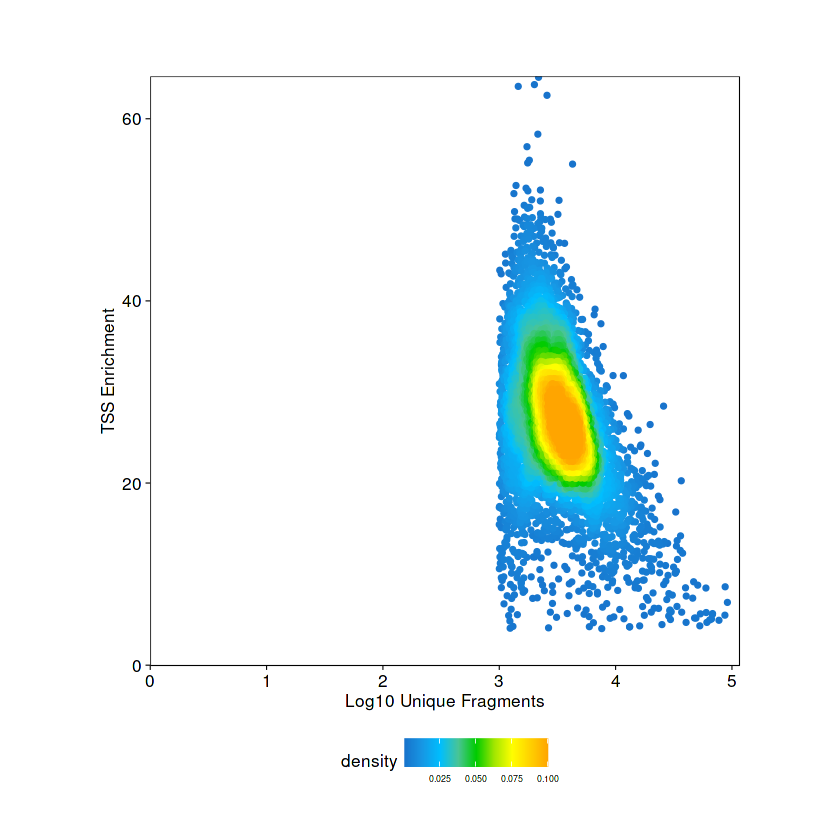

In [7]:
df <- getCellColData(project, select = c("log10(nFrags)", "TSSEnrichment"))
plot.tss.frags <- ggPoint(x = df[,1], y = df[,2], colorDensity = TRUE, continuousSet = "sambaNight",
              xlabel = "Log10 Unique Fragments", ylabel = "TSS Enrichment",
              xlim = c(0, quantile(df[,1], probs = 1)+0.1), ylim = c(0, quantile(df[,2], probs = 1)+0.1))

#Create a pdf file in the Plots directory of the project
plotPDF(plot.tss.frags, name = "TSS-vs-Frags.pdf", ArchRProj = project, addDOC = FALSE)

plot.tss.frags



Plot TSS metrics:


1 


1 


Picking joint bandwidth of 1.42



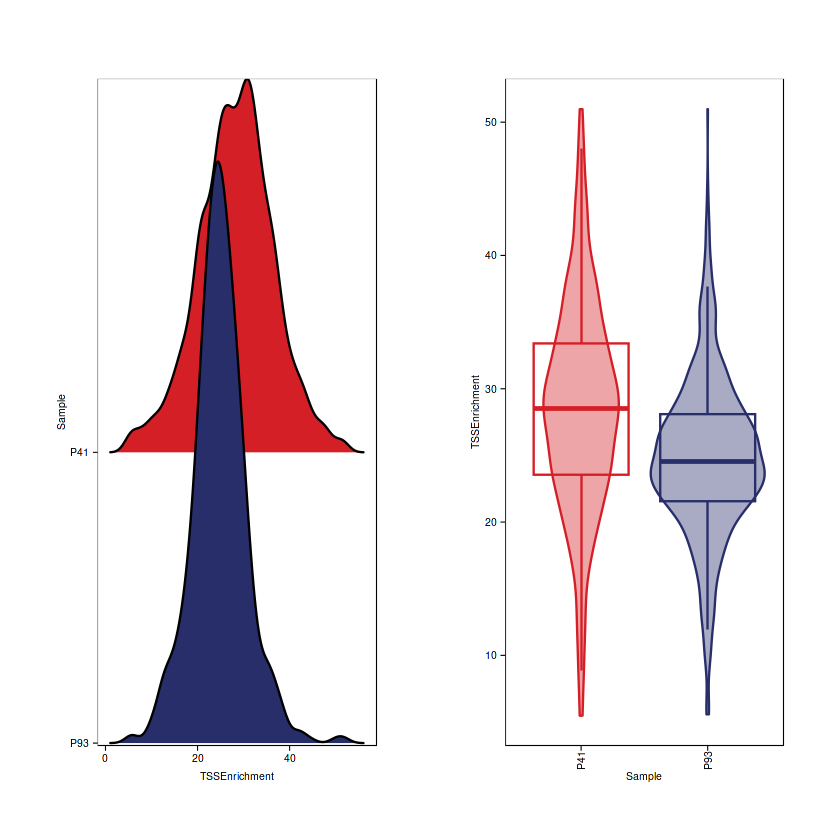

In [8]:
plot.tss.v1 <- plotGroups(ArchRProj = project, groupBy = "Sample",
  colorBy = "cellColData", name = "TSSEnrichment", plotAs = "ridges"
)

plot.tss.v2 <- plotGroups(ArchRProj = project, groupBy = "Sample",
  colorBy = "cellColData", name = "TSSEnrichment", plotAs = "violin", alpha = 0.4, addBoxPlot = TRUE
)

plot.tss.v1 | plot.tss.v2



Plot fragment metrics:


1 


1 


Picking joint bandwidth of 0.0515



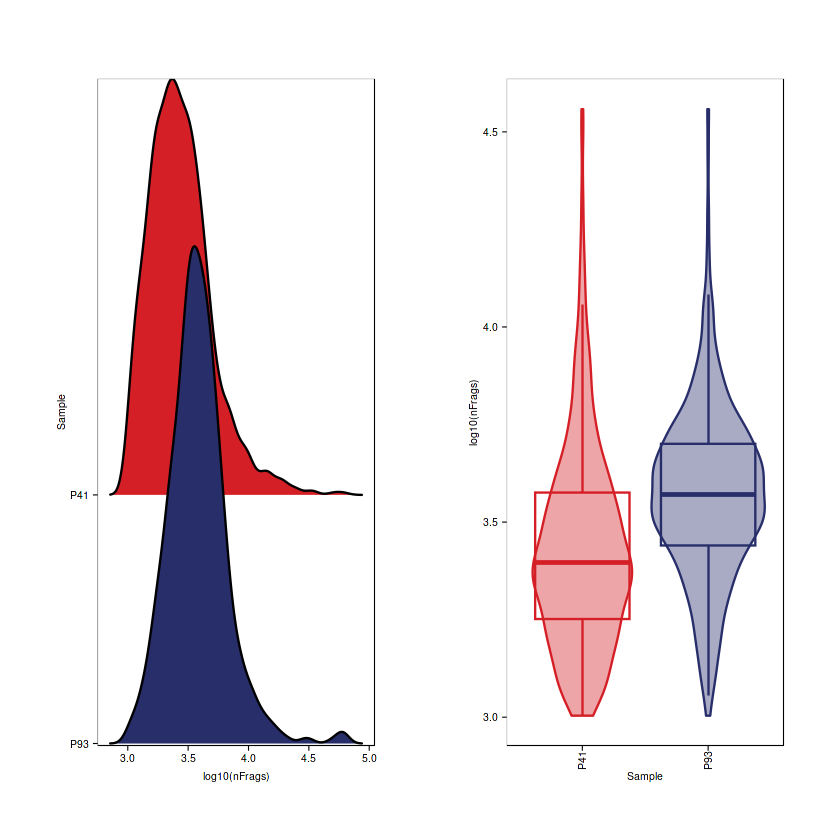

In [9]:
plot.frags.v1 <- plotGroups(ArchRProj = project, groupBy = "Sample",
  colorBy = "cellColData", name = "log10(nFrags)", plotAs = "ridges"
)

plot.frags.v2 <- plotGroups(ArchRProj = project, groupBy = "Sample",
  colorBy = "cellColData", name = "log10(nFrags)", plotAs = "violin", alpha = 0.4, addBoxPlot = TRUE
)

plot.frags.v1 | plot.frags.v2


In [10]:
ArrowFiles <- createArrowFiles(
  inputFiles = inputFiles,
  sampleNames = names(inputFiles),
  minTSS = 4,
  minFrags = 1000,
  addTileMat = TRUE,
  addGeneScoreMat = TRUE
)


Using GeneAnnotation set by addArchRGenome(Hg19)!

Using GeneAnnotation set by addArchRGenome(Hg19)!

ArchR logging to : ArchRLogs/ArchR-createArrows-33c717c358b3-Date-2023-07-26_Time-19-51-54.419396.log
If there is an issue, please report to github with logFile!

Cleaning Temporary Files

2023-07-26 19:51:54.48567 : Batch Execution w/ safelapply!, 0 mins elapsed.

(P41 : 1 of 2) Checking if completed file exists!

2023-07-26 19:51:54.508786 : (P41 : 1 of 2) Arrow Exists! Marking as completed since force = FALSE!, 0 mins elapsed.

(P93 : 2 of 2) Checking if completed file exists!

2023-07-26 19:51:54.531107 : (P93 : 2 of 2) Arrow Exists! Marking as completed since force = FALSE!, 0.001 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-createArrows-33c717c358b3-Date-2023-07-26_Time-19-51-54.419396.log



#3. Doublet detection
A source of touble in single-cell data is the contribution of "doublets" to the analysis (a doublet refers to a single droplet that received more than one nucleus).
To predict which “cells” are actually doublets, ArchR synthesizes in silico doublets from the data by mixing the reads from thousands of combinations of individual cells.
It projects these synthetic doublets into the UMAP embedding and identify their nearest neighbor. By iterating this procedure thousands of times, it can identify “cells” in the data whose signal looks very similar to synthetic doublets.
Here, we identify the doublets.


In [11]:
doubletScores <- addDoubletScores(
  input = ArrowFiles,
  k = 10, #Refers to how many cells near a "pseudo-doublet" to count.
  knnMethod = "UMAP", #Refers to the embedding to use for nearest neighbor search.
  LSIMethod = 1
)


ArchR logging to : ArchRLogs/ArchR-addDoubletScores-33c714eab7e-Date-2023-07-26_Time-19-51-54.564724.log
If there is an issue, please report to github with logFile!

2023-07-26 19:51:54.620066 : Batch Execution w/ safelapply!, 0 mins elapsed.

2023-07-26 19:51:54.630409 : P41 (1 of 2) :  Computing Doublet Statistics, 0 mins elapsed.

P41 (1 of 2) : UMAP Projection R^2 = 0.98794

P41 (1 of 2) : UMAP Projection R^2 = 0.98794

2023-07-26 19:54:37.901057 : P93 (2 of 2) :  Computing Doublet Statistics, 2.721 mins elapsed.

P93 (2 of 2) : UMAP Projection R^2 = 0.9659

P93 (2 of 2) : UMAP Projection R^2 = 0.9659

ArchR logging successful to : ArchRLogs/ArchR-addDoubletScores-33c714eab7e-Date-2023-07-26_Time-19-51-54.564724.log



#4. Creation of ArchR project
As explain before, we generate a ArchR project to easily manipulate the scATAC-seq generated by ArchR.


In [12]:
project <- ArchRProject(
  ArrowFiles = ArrowFiles,
  outputDirectory = "Analysis_scATACseq",
  copyArrows = TRUE #This is recommened so that you maintain an unaltered copy for later usage.
)


Using GeneAnnotation set by addArchRGenome(Hg19)!

Using GeneAnnotation set by addArchRGenome(Hg19)!

Validating Arrows...

Getting SampleNames...

1 
2 


Copying ArrowFiles to Ouptut Directory! If you want to save disk space set copyArrows = FALSE

1 
2 


Getting Cell Metadata...

1 
2 


Merging Cell Metadata...

Initializing ArchRProject...


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
   


We can easily list the matrix items present in the project


In [13]:
getAvailableMatrices(project)



[1] "GeneScoreMatrix" "TileMatrix"

Strict quality control (QC) of scATAC-seq data is essential to remove the contribution of low-quality cells.

ArchR consider three characteristics of data:

1. The fragment size distribution. Due to nucleosomal periodicity, we expect to see depletion of fragments that are the length of DNA wrapped around a nucleosome (approximately 147 bp).

2. The TSS enrichment (signal-to-background ratio). Low signal-to-background ratio is often attributed to dead or dying cells which have de-chromatized DNA which allows for random transposition genome-wide.

3. The number of unique nuclear fragments (i.e. not mapping to mitochondrial DNA).
We can appreciate the QC and the main metrics of samples using some plots:

Plot QC metrics:


Plotting Ggplot!



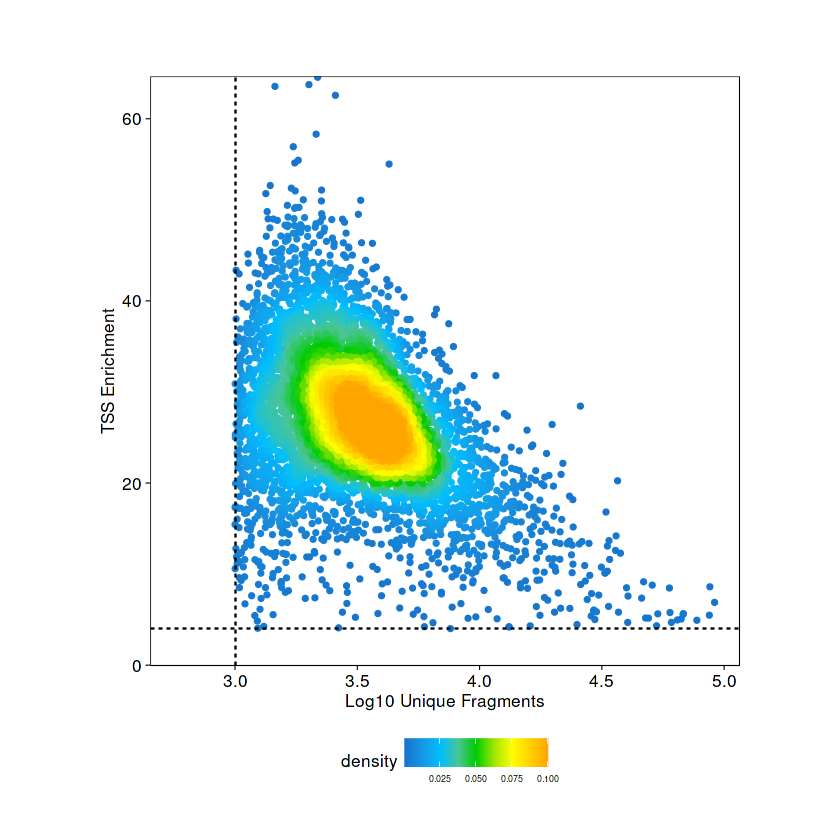

In [14]:
df <- getCellColData(project, select = c("log10(nFrags)", "TSSEnrichment"))
plot.tss.frags <- ggPoint(x = df[,1], y = df[,2], colorDensity = TRUE, continuousSet = "sambaNight",
              xlabel = "Log10 Unique Fragments", ylabel = "TSS Enrichment",
              xlim = c(log10(450), quantile(df[,1], probs = 1)+0.1), ylim = c(0, quantile(df[,2], probs = 1)+0.1)) +
  geom_hline(yintercept = 4, lty = "dashed", col="black") + geom_vline(xintercept = log10(1000), lty = "dashed", col="black")

#Create a pdf file in the Plots directory of the project
plotPDF(plot.tss.frags, name = "TSS-vs-Frags.pdf", ArchRProj = project, addDOC = FALSE)

plot.tss.frags



Plot TSS metrics:


1 


1 


Picking joint bandwidth of 1.42



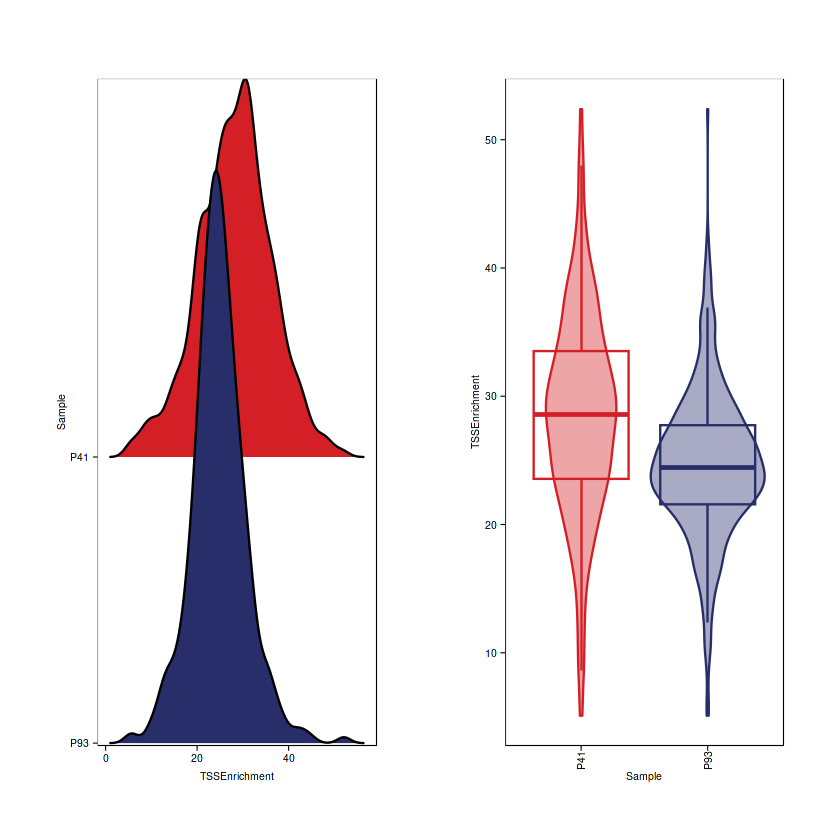

In [15]:
plot.tss.v1 <- plotGroups(ArchRProj = project, groupBy = "Sample",
  colorBy = "cellColData", name = "TSSEnrichment", plotAs = "ridges"
)

plot.tss.v2 <- plotGroups(ArchRProj = project, groupBy = "Sample",
  colorBy = "cellColData", name = "TSSEnrichment", plotAs = "violin", alpha = 0.4, addBoxPlot = TRUE
)

plot.tss.v1 | plot.tss.v2



Plot fragment metrics:


1 


1 


Picking joint bandwidth of 0.0517



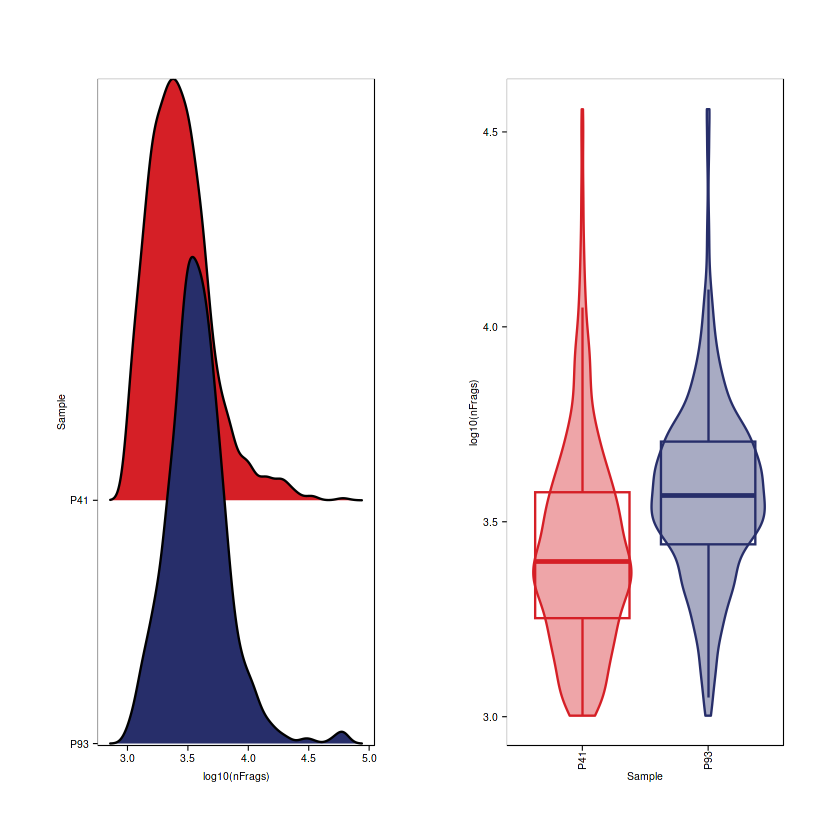

In [16]:
plot.frags.v1 <- plotGroups(ArchRProj = project, groupBy = "Sample",
  colorBy = "cellColData", name = "log10(nFrags)", plotAs = "ridges"
)

plot.frags.v2 <- plotGroups(ArchRProj = project, groupBy = "Sample",
  colorBy = "cellColData", name = "log10(nFrags)", plotAs = "violin", alpha = 0.4, addBoxPlot = TRUE
)

plot.frags.v1 | plot.frags.v2



Filter the doublets


In [17]:
project <- filterDoublets(ArchRProj = project)



Filtering 210 cells from ArchRProject!

	P41 : 122 of 3495 (3.5%)

	P93 : 88 of 2982 (3%)




Sample Fragment Size Distribution and TSS Enrichment Profiles


ArchR logging to : ArchRLogs/ArchR-plotTSSEnrichment-33c76882f0dc-Date-2023-07-26_Time-19-57-06.293379.log
If there is an issue, please report to github with logFile!

2023-07-26 19:57:06.744156 : P41 Computing TSS (1 of 2)!, 0.008 mins elapsed.

2023-07-26 19:57:31.980993 : P41 Finished Computing TSS (1 of 2)!, 0.428 mins elapsed.

2023-07-26 19:57:32.043975 : P93 Computing TSS (2 of 2)!, 0.429 mins elapsed.

2023-07-26 19:57:57.522478 : P93 Finished Computing TSS (2 of 2)!, 0.854 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-plotTSSEnrichment-33c76882f0dc-Date-2023-07-26_Time-19-57-06.293379.log

ArchR logging to : ArchRLogs/ArchR-plotFragmentSizes-33c76b23d897-Date-2023-07-26_Time-19-57-57.631685.log
If there is an issue, please report to github with logFile!

2023-07-26 19:57:57.761704 : P41 Computing FragmentSizes (1 of 2)!, 0.002 mins elapsed.

2023-07-26 19:58:12.568353 : P41 Finished Computing FragmentSizes (1 of 2)!, 0.249 mins elapsed.

2023-07-26 19:58:12.6018

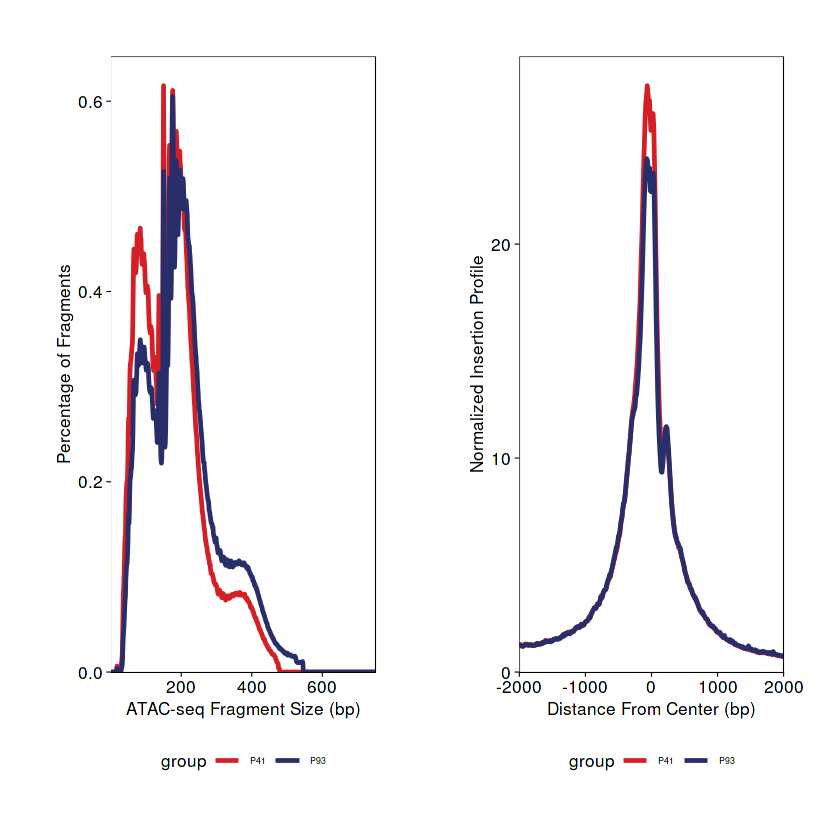

In [18]:
plot.tss.v3 <- plotTSSEnrichment(ArchRProj = project)
plot.frags.v3 <- plotFragmentSizes(ArchRProj = project)
plot.frags.v3 | plot.tss.v3


#5. Normalization, dimensional reduction, batch effect correction, clustering and others step

##5.1. Normalization and dimensional reduction
scATAC-seq generates a sparse insertion counts matrix (500-bp tiles; binary data of ~6 million of features) making it impossible to identify variable peaks for standard dimensionality reduction. To get around this issue, ArchR use LSI (Latent Semantic Indexing), a layered dimensionality reduction approach for sparse and noisy data.

Rather than identifying the most variable peaks, ArchR tries using the most accessible features as input to LSI.

However, when running multiple samples the results could shown high degrees of noise and low reproducibility.

To remedy this, ArchR introduced the “iterative LSI” approach (Satpathy, Granja et al., 2019), which computes an initial LSI transformation on the most accessible tiles and identifies lower resolution clusters that are not batch confounded.

1- This approach computes an initial LSI transformation on the most accessible tiles and identifies lower resolution clusters that are not batch confounded.

2- ArchR computes the average accessibility for each of these clusters across all features. ArchR then identifies the most variable peaks across these clusters and uses these features for LSI again.

3- In this second iteration, the most variable peaks are more similar to the variable genes used in scRNA-seq LSI implementations.

This approach minimizes observed batch effects and allow dimensionality reduction operations on a more reasonably sized feature matrix.
<center>

![](./Figures/iLSI.png)

</center>


In [19]:
project_Normalized <- addIterativeLSI(ArchRProj = project, iterations = 2,
                                      #sampleCellsPre = 50000, #Number of cells to use for iterations prior to the last in order to perform the sub-sampled LSI and sub-sampled clustering
                                      #clusterParams = list(resolution = 0.1, sampleCells = 50000, maxClusters = 6, n.start = 10), #Can be modified to optimized clusterization. Important to modify the number of cells used for the clusterization if you use a lot of cells
                                      useMatrix = "TileMatrix", name = "IterativeLSI", varFeatures = 25000)


Checking Inputs...

ArchR logging to : ArchRLogs/ArchR-addIterativeLSI-33c73c84559f-Date-2023-07-26_Time-19-58-28.688328.log
If there is an issue, please report to github with logFile!

2023-07-26 19:58:28.887331 : Computing Total Across All Features, 0.001 mins elapsed.

2023-07-26 19:58:30.362743 : Computing Top Features, 0.026 mins elapsed.

###########
2023-07-26 19:58:32.019686 : Running LSI (1 of 2) on Top Features, 0.054 mins elapsed.
###########

2023-07-26 19:58:32.045098 : Creating Partial Matrix, 0.054 mins elapsed.

2023-07-26 19:58:43.10977 : Computing LSI, 0.239 mins elapsed.

2023-07-26 19:59:06.940333 : Identifying Clusters, 0.636 mins elapsed.

2023-07-26 19:59:17.378832 : Identified 6 Clusters, 0.81 mins elapsed.

2023-07-26 19:59:17.392135 : Saving LSI Iteration, 0.81 mins elapsed.

2023-07-26 19:59:44.176013 : Creating Cluster Matrix on the total Group Features, 1.256 mins elapsed.

2023-07-26 20:00:23.861068 : Computing Variable Features, 1.918 mins elapsed.

#####

##5.2. Batch effect correction
Sometimes the iterative LSI approach isn’t enough to correct strong batch effect differences.
For this reason, ArchR implements a commonly used batch effect correction tool called Harmony (Korsunsky et al., 2019) which was originally designed for scRNA-seq.


In [20]:
project_Normalized <- addHarmony(ArchRProj = project_Normalized, reducedDims = "IterativeLSI",name = "Harmony", groupBy = "Sample")

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony converged after 3 iterations



##5.3. UMAP
Run UMAP in ArchR


20:00:59 UMAP embedding parameters a = 0.7669 b = 1.223

20:00:59 Read 6267 rows and found 30 numeric columns

20:00:59 Using Annoy for neighbor search, n_neighbors = 40

20:00:59 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

20:01:00 Writing NN index file to temp file /tmp/RtmpT6zK1e/file33c7473c1b7f

20:01:00 Searching Annoy index using 1 thread, search_k = 4000

20:01:04 Annoy recall = 100%

20:01:05 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 40

20:01:06 Initializing from normalized Laplacian + noise (using irlba)

20:01:06 Commencing optimization for 500 epochs, with 373874 positive edges

20:01:17 Optimization finished

20:01:17 Creating temp model dir /tmp/RtmpT6zK1e/dir33c71fdb7776

20:01:17 Creating dir /tmp/RtmpT6zK

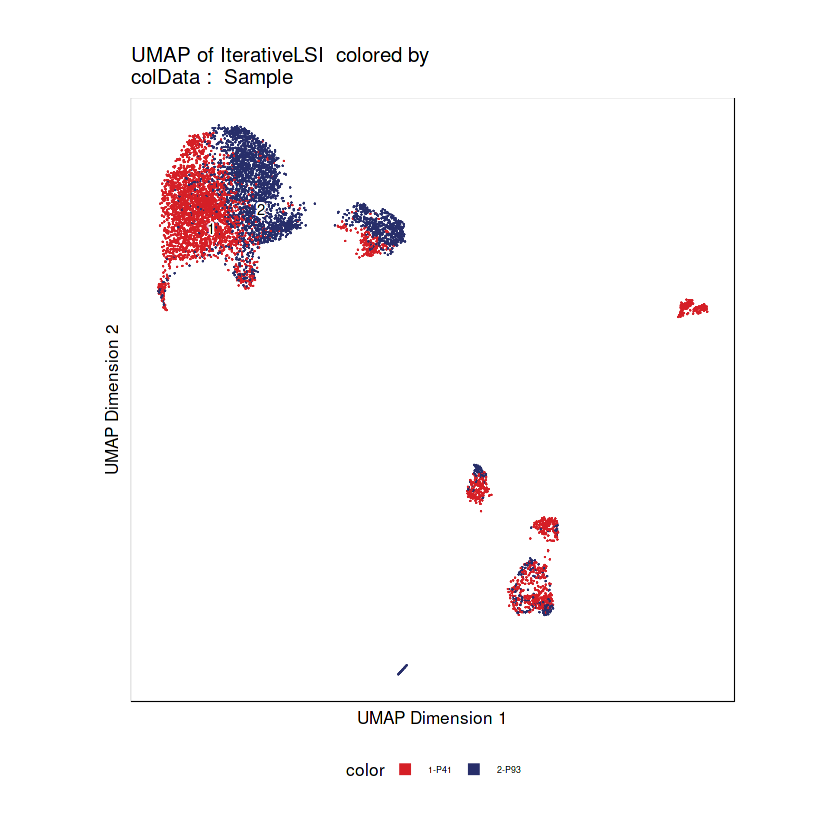

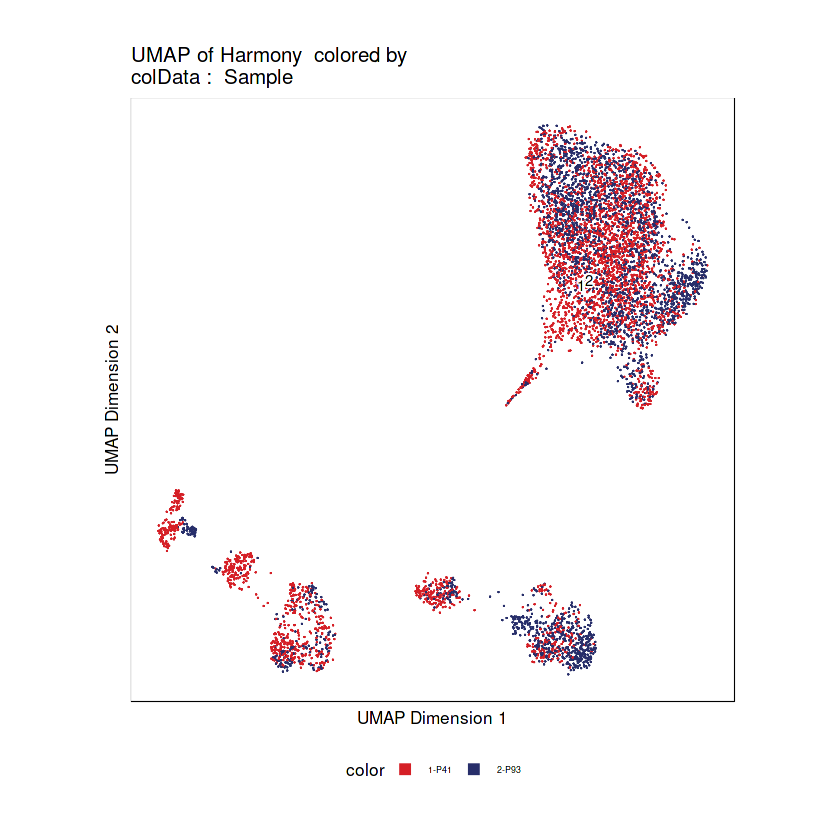

In [21]:
project_Normalized <- addUMAP(ArchRProj = project_Normalized, reducedDims = "IterativeLSI", name = "UMAP")

#Display UMAP
plotEmbedding(ArchRProj = project_Normalized, colorBy = "cellColData", name = "Sample", embedding = "UMAP", size=0.1)

project_Normalized <- addUMAP(ArchRProj = project_Normalized, reducedDims = "Harmony", name = "UMAP", force=TRUE)

#Display UMAP
plotEmbedding(ArchRProj = project_Normalized, colorBy = "cellColData", name = "Sample", embedding = "UMAP", size=0.1)


##5.4. Clustering
To identify clusters, ArchR allows to use same method as Seurat or Scran. We have selected the same method describe the first day and used in Seurat package.


In [22]:
for(i in seq(0,0.9,0.1)){
  project_Normalized <- addClusters(input = project_Normalized, reducedDims = "Harmony",method = "Seurat",
                                    name = paste("Clusters.res",i,sep=""),resolution = i, verbose = FALSE)
                        #warning to the reducedDims: "Harmony" or "IterativeLSI"
    }


ArchR logging to : ArchRLogs/ArchR-addClusters-33c75b372996-Date-2023-07-26_Time-20-01-43.662606.log
If there is an issue, please report to github with logFile!

ArchR logging to : ArchRLogs/ArchR-addClusters-33c761e8cc90-Date-2023-07-26_Time-20-01-54.713718.log
If there is an issue, please report to github with logFile!

ArchR logging to : ArchRLogs/ArchR-addClusters-33c74dc1292f-Date-2023-07-26_Time-20-02-06.474924.log
If there is an issue, please report to github with logFile!

ArchR logging to : ArchRLogs/ArchR-addClusters-33c776d50039-Date-2023-07-26_Time-20-02-16.847382.log
If there is an issue, please report to github with logFile!

ArchR logging to : ArchRLogs/ArchR-addClusters-33c725d0252e-Date-2023-07-26_Time-20-02-27.232687.log
If there is an issue, please report to github with logFile!

ArchR logging to : ArchRLogs/ArchR-addClusters-33c72a8ce32a-Date-2023-07-26_Time-20-02-36.763593.log
If there is an issue, please report to github with logFile!

ArchR logging to : ArchRLogs

##5.5. Save and load a project
Save


In [23]:
saveArchRProject(ArchRProj = project_Normalized,
                 outputDirectory = file.path(getwd(),"Analysis_scATACseq"))


Saving ArchRProject...

Loading ArchRProject...

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
         

class: ArchRProject 
outputDirectory: /content/scATACseqWorkshop/Analysis_scATACseq 
samples(2): P41 P93
sampleColData names(1): ArrowFiles
cellColData names(25): Sample TSSEnrichment ... Clusters.res0.8
  Clusters.res0.9
numberOfCells(1): 6267
medianTSS(1): 26.466
medianFrags(1): 3070


Load


In [24]:
project_Normalized <- loadArchRProject(path = file.path(getwd(),"Analysis_scATACseq"), force = TRUE, showLogo = FALSE)



Successfully loaded ArchRProject!



#6. Exploration of data using Gene estimation




##6.1. Visualization of clustering using Clustree
Clustree is an useful tool to explore the links between the clusters from different resolutions.

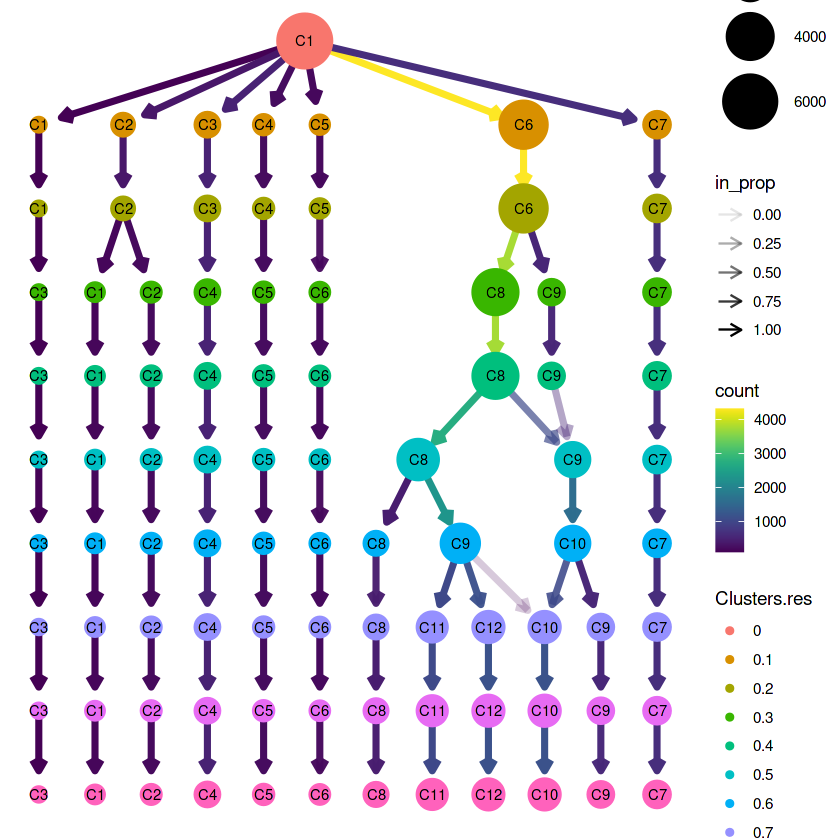

In [25]:
tmp.clustree.datatable<-as.data.frame(project_Normalized@cellColData)
clustree(tmp.clustree.datatable, prefix="Clusters.res")



##6.2. Visualization of clustering on UMAP


ArchR logging to : ArchRLogs/ArchR-plotEmbedding-33c758f6eead-Date-2023-07-26_Time-20-03-39.400644.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-33c758f6eead-Date-2023-07-26_Time-20-03-39.400644.log

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-33c712e978f3-Date-2023-07-26_Time-20-03-39.806576.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-33c712e978f3-Date-2023-07-26_Time-20-03-39.806576.log

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-33c710106603-Date-2023-07-26_Time-20-03-42.200533.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-33

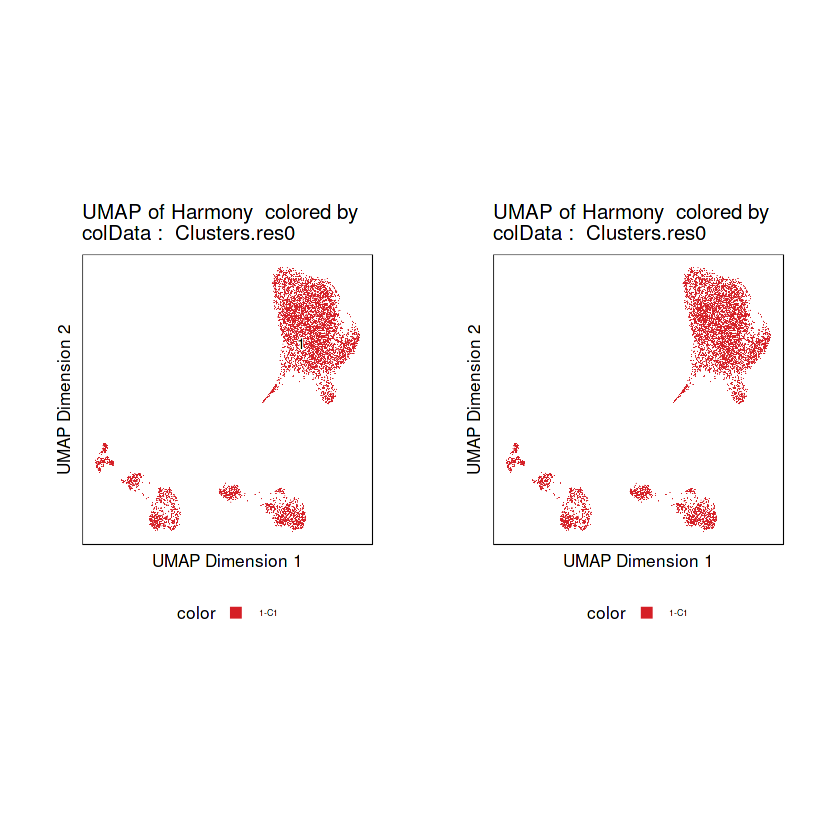

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-33c7709bec1c-Date-2023-07-26_Time-20-03-52.120174.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-33c7709bec1c-Date-2023-07-26_Time-20-03-52.120174.log

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-33c7216f5ab8-Date-2023-07-26_Time-20-03-52.558428.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-33c7216f5ab8-Date-2023-07-26_Time-20-03-52.558428.log



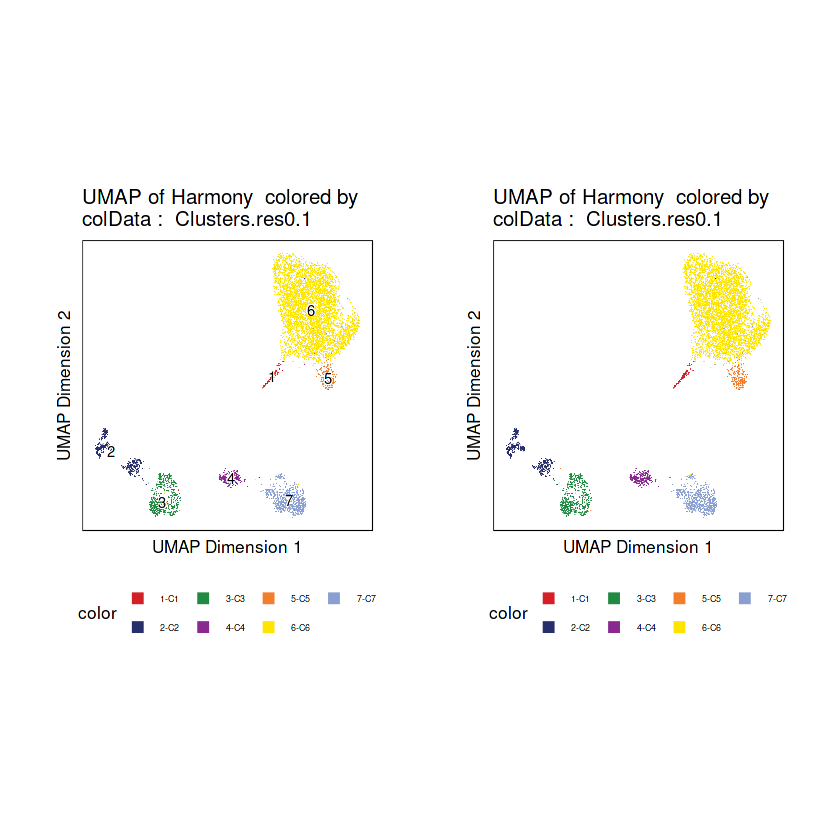

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-33c712309c54-Date-2023-07-26_Time-20-03-57.208308.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-33c712309c54-Date-2023-07-26_Time-20-03-57.208308.log

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-33c72c0effee-Date-2023-07-26_Time-20-03-57.628226.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-33c72c0effee-Date-2023-07-26_Time-20-03-57.628226.log



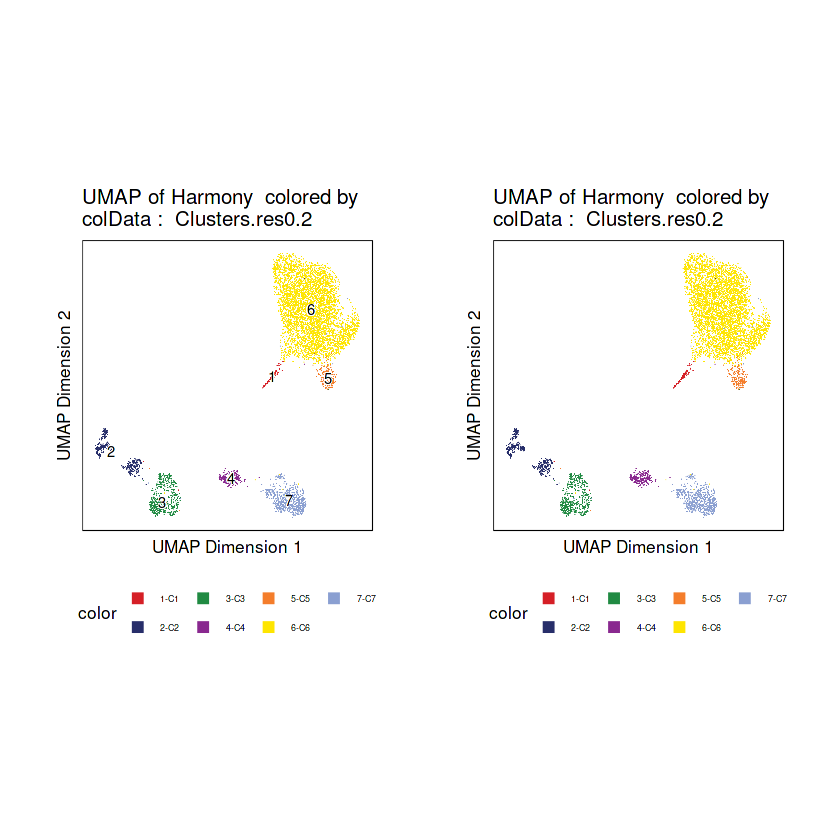

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-33c744d9da82-Date-2023-07-26_Time-20-04-02.765058.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-33c744d9da82-Date-2023-07-26_Time-20-04-02.765058.log

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-33c770c2ffe5-Date-2023-07-26_Time-20-04-03.305428.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-33c770c2ffe5-Date-2023-07-26_Time-20-04-03.305428.log



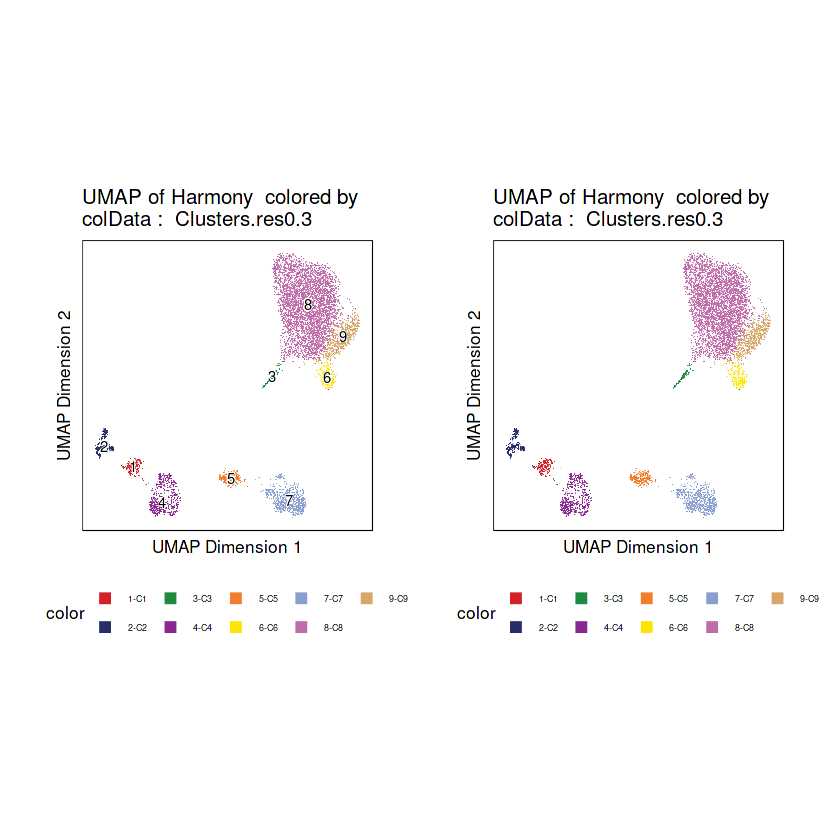

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-33c760e5af64-Date-2023-07-26_Time-20-04-08.246933.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-33c760e5af64-Date-2023-07-26_Time-20-04-08.246933.log

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-33c738876574-Date-2023-07-26_Time-20-04-08.660342.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-33c738876574-Date-2023-07-26_Time-20-04-08.660342.log



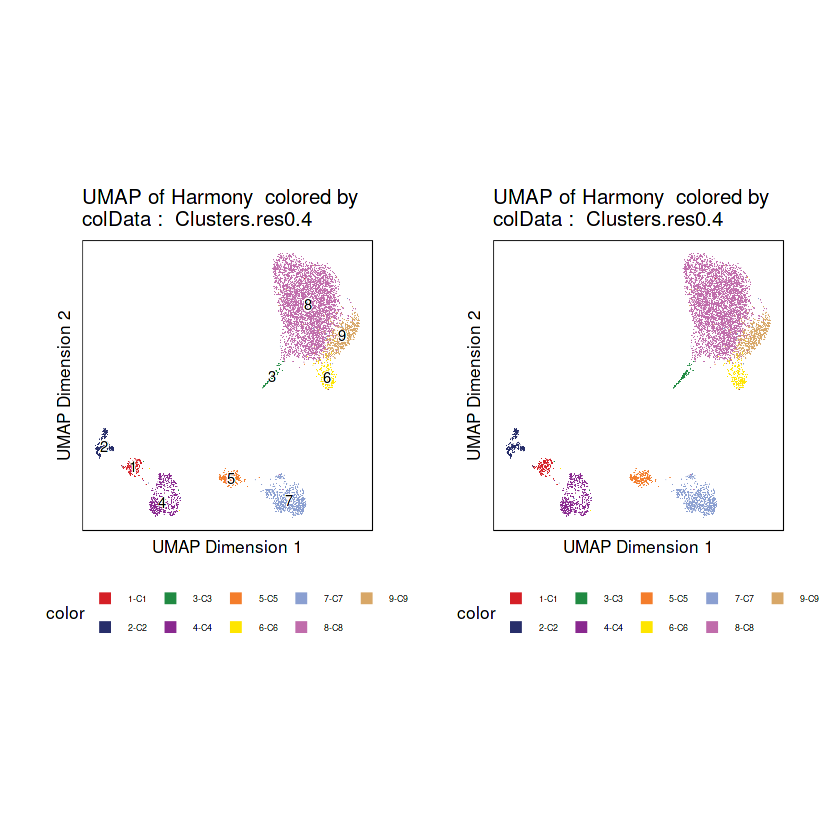

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-33c72fedc563-Date-2023-07-26_Time-20-04-12.393618.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-33c72fedc563-Date-2023-07-26_Time-20-04-12.393618.log

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-33c72f978e0c-Date-2023-07-26_Time-20-04-13.020145.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-33c72f978e0c-Date-2023-07-26_Time-20-04-13.020145.log



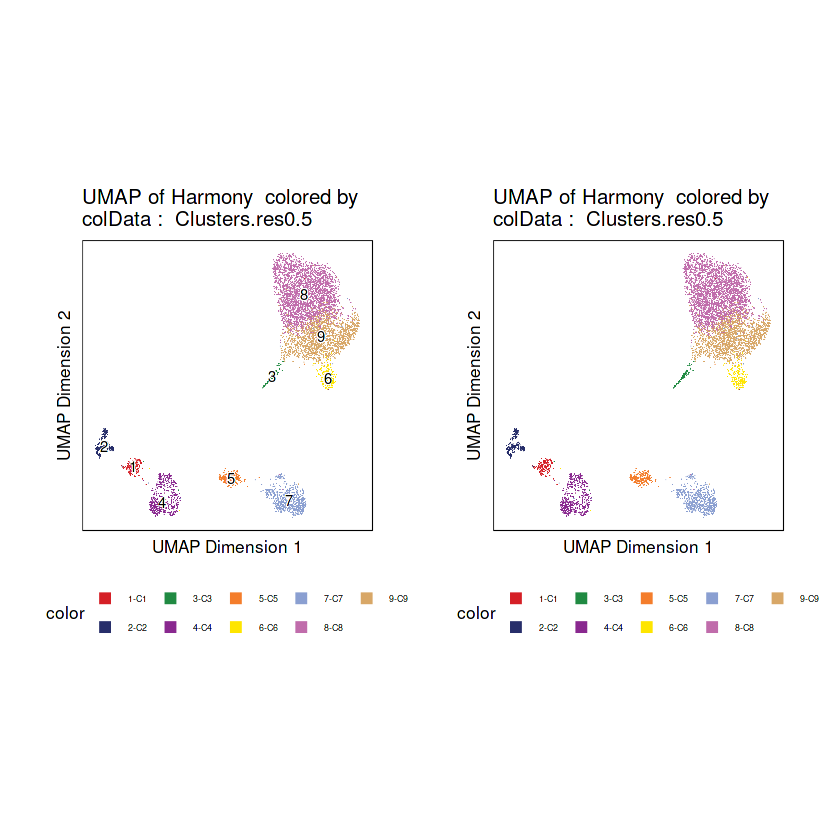

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-33c7564e5b20-Date-2023-07-26_Time-20-04-18.049701.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-33c7564e5b20-Date-2023-07-26_Time-20-04-18.049701.log

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-33c7228045d0-Date-2023-07-26_Time-20-04-18.503453.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-33c7228045d0-Date-2023-07-26_Time-20-04-18.503453.log



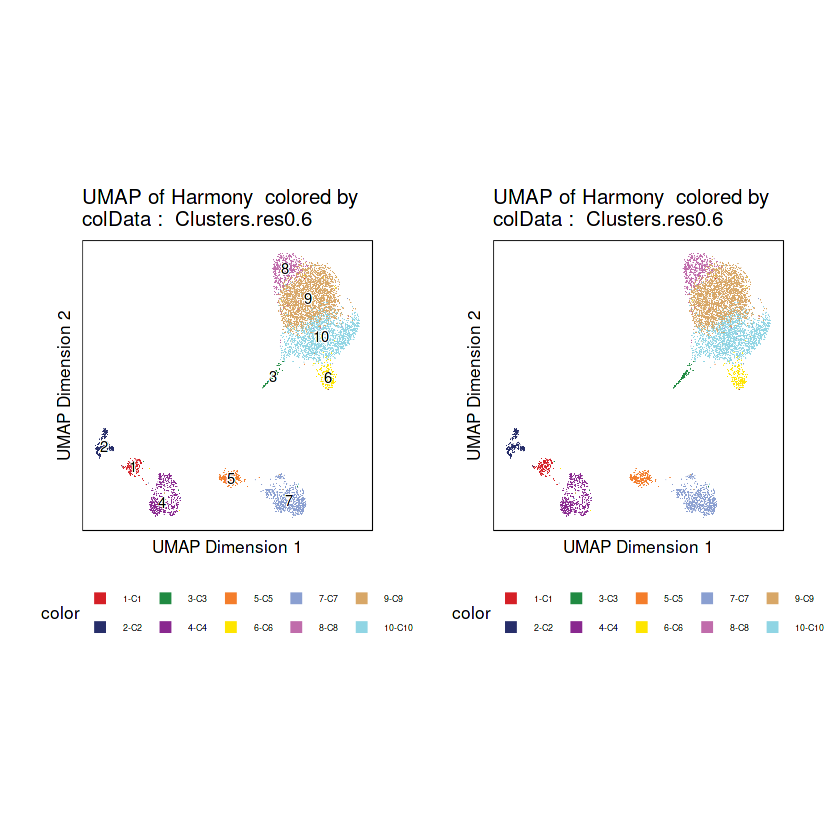

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-33c77d7cdc96-Date-2023-07-26_Time-20-04-22.156449.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-33c77d7cdc96-Date-2023-07-26_Time-20-04-22.156449.log

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-33c75c86253-Date-2023-07-26_Time-20-04-22.575361.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-33c75c86253-Date-2023-07-26_Time-20-04-22.575361.log



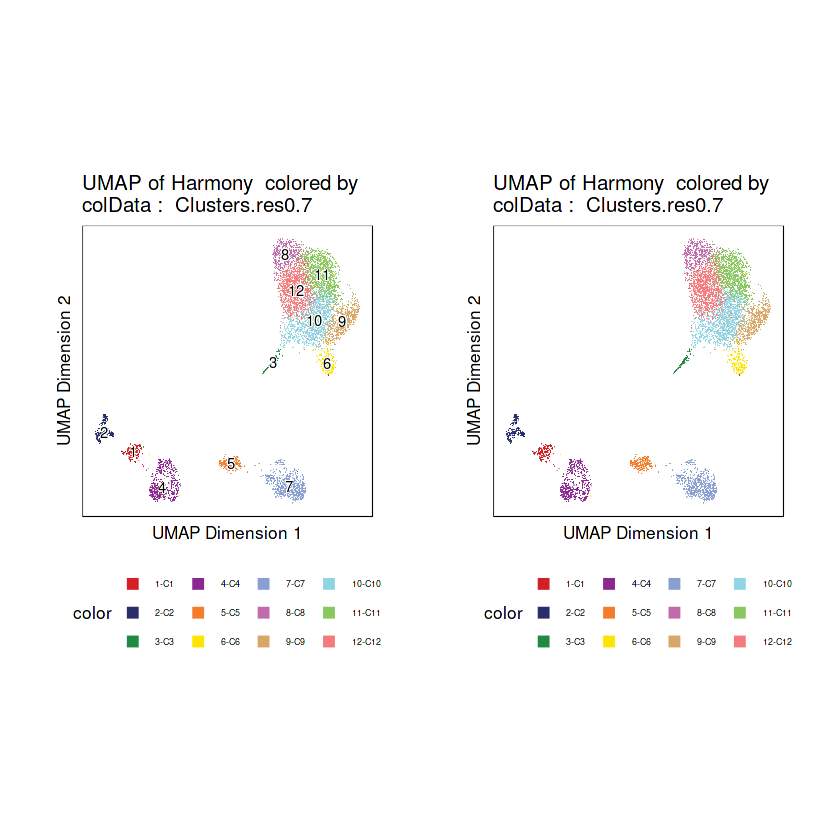

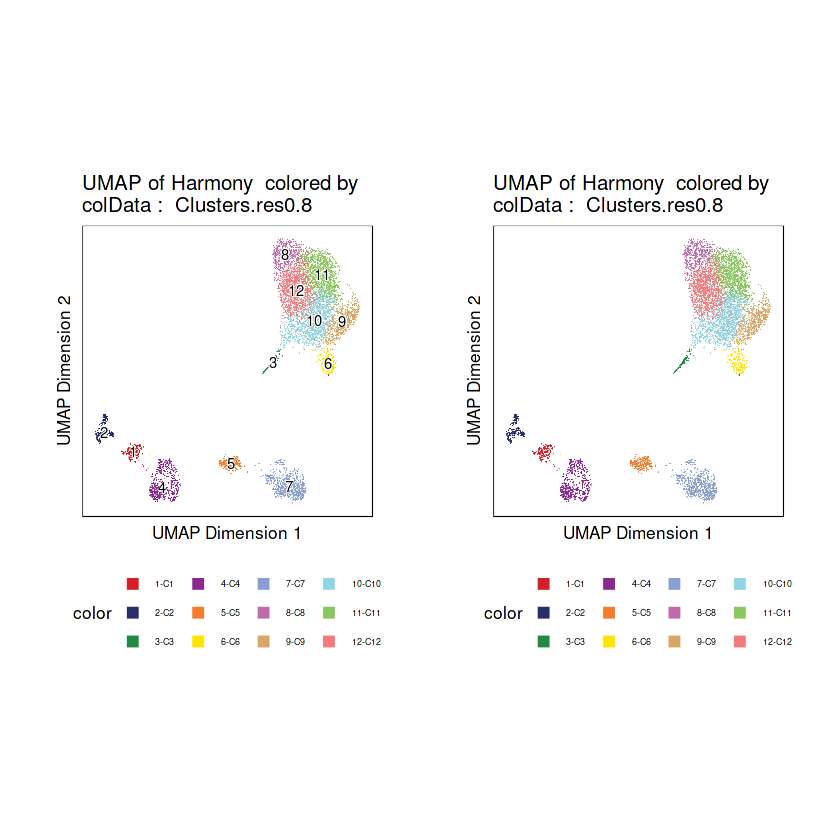

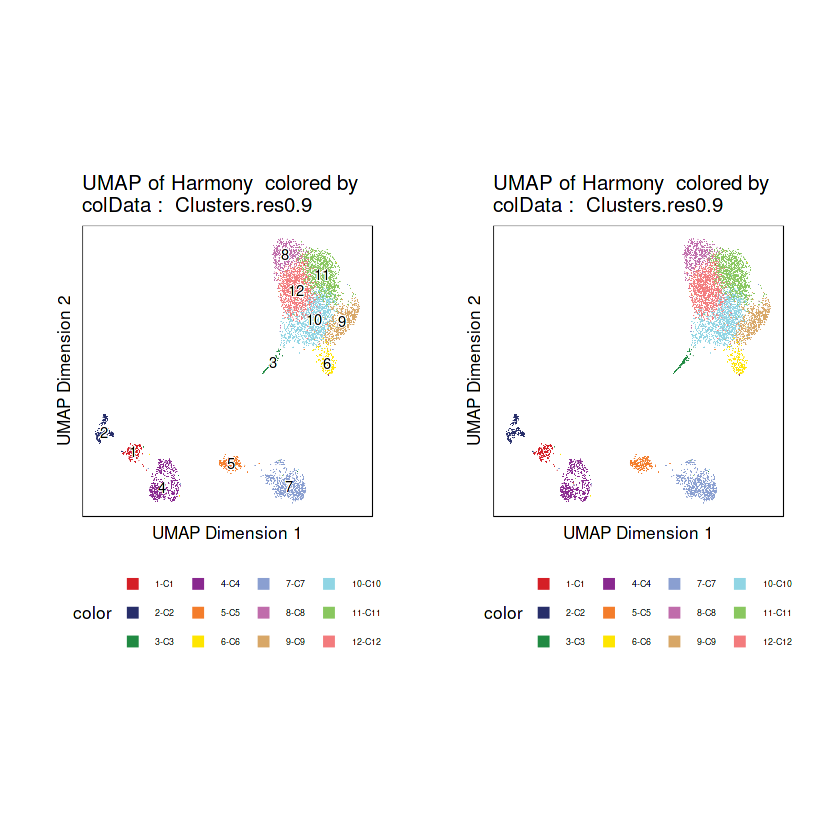

In [26]:
for(i in seq(0,0.9,0.1)){
  plot.umap.resi<-plotEmbedding(ArchRProj = project_Normalized, colorBy = "cellColData", name = paste("Clusters.res",i,sep=""), embedding = "UMAP", size=0.1)
  plot.umap.woLabel.resi<-plotEmbedding(ArchRProj = project_Normalized, colorBy = "cellColData", name = paste("Clusters.res",i,sep=""), embedding = "UMAP", size=0.1, labelMeans=FALSE)

  print(plot.umap.resi | plot.umap.woLabel.resi)
}


##6.3. Characterization of clusters
At this step, we select a specific resolution to explore in details the GeneScore characterize the different clusters.
For that, we will identify marker genes (based on gene scores, or estimation of gene expression) of clusters.
In short, ArchR estimates gene scores using the local accessibility of the gene region that includes the promoter and gene body, but imposes an exponential weight that accounts for the activity of putative distal regulatory elements as a function of distance.

![<i><font size=1 color="grey">from ArchR manual</font></i>](./Figures/GeneActivityScore_Schematic.png){width=70% height=50%}

Remarks: ArchR can used gene, peak or transcription factor motif features. Here, ArchR identify the genes that appear to be uniquely active in each cluster at the resolution 0.4.


In [27]:
slct.res="res0.7"

markersGS.slctRes <- getMarkerFeatures(ArchRProj = project_Normalized,
                                       useMatrix = "GeneScoreMatrix",
                                       groupBy = paste("Clusters.",slct.res,sep=""),
                                       bias = c("TSSEnrichment", "log10(nFrags)"),
                                       testMethod = "wilcoxon")

markerList <- getMarkers(markersGS.slctRes, cutOff = "FDR <= 0.05 & Log2FC >= 0.2")

i=names(markerList)[1]
markerList[[i]]

for(i in names(markerList)){
  write.table(markerList[[i]],sep="\t", row.names=FALSE, col.names=TRUE, quote=FALSE,
              file=file.path(work_dir,paste(i,".res",slct.res,".mGenesList.tsv",sep="")))
}


ArchR logging to : ArchRLogs/ArchR-getMarkerFeatures-33c765cb6cb1-Date-2023-07-26_Time-20-04-30.120028.log
If there is an issue, please report to github with logFile!

MatrixClass = Sparse.Double.Matrix

2023-07-26 20:04:30.325013 : Matching Known Biases, 0.002 mins elapsed.

2023-07-26 20:04:32.240953 : Computing Pairwise Tests (1 of 12), 0.034 mins elapsed.

Pairwise Test C1 : Seqnames chr1

Pairwise Test C1 : Seqnames chr10

Pairwise Test C1 : Seqnames chr11

Pairwise Test C1 : Seqnames chr12

Pairwise Test C1 : Seqnames chr13

Pairwise Test C1 : Seqnames chr14

Pairwise Test C1 : Seqnames chr15

Pairwise Test C1 : Seqnames chr16

Pairwise Test C1 : Seqnames chr17

Pairwise Test C1 : Seqnames chr18

Pairwise Test C1 : Seqnames chr19

Pairwise Test C1 : Seqnames chr2

Pairwise Test C1 : Seqnames chr20

Pairwise Test C1 : Seqnames chr21

Pairwise Test C1 : Seqnames chr22

Pairwise Test C1 : Seqnames chr3

Pairwise Test C1 : Seqnames chr4

Pairwise Test C1 : Seqnames chr5

Pairwise Tes

DataFrame with 1002 rows and 9 columns
      seqnames     start       end  strand    name     idx    Log2FC
         <Rle>   <array>   <array> <array> <array> <array> <numeric>
1902      chr1 201977073 201986315       1    ELF3    1902   3.45790
158       chr1  10856733  10696666       2   CASZ1     158   2.61542
6467     chr14  38064325  38058757       2   FOXA1     206   6.61010
1903      chr1 202092029 202098634       1 GPR37L1    1903   3.15191
12871     chr2 133174147 133404169       1   GPR39     812   5.10259
...        ...       ...       ...     ...     ...     ...       ...
4273     chr11  86666440  86656717       2    FZD4    1070   1.83333
11182    chr19  36004560  35988119       2    DMKN     730   1.77787
8021     chr16   4466962   4404543       2   CORO7     198   1.02471
12694     chr2 102686836 102796334       1   IL1R1     635   1.57607
12972     chr2 166651169 166604313       2  GALNT3     913   1.71395
              FDR  MeanDiff
        <numeric> <numeric>
1902  2.


To visualize the marker genes, we can produce a heatmap:


ArchR logging to : ArchRLogs/ArchR-plotMarkerHeatmap-33c7325c1af6-Date-2023-07-26_Time-20-11-02.771039.log
If there is an issue, please report to github with logFile!

Printing Top Marker Genes:

C1:

	MIR4251, ARHGEF16, C1orf127, CAMK2N1, KDF1, NKAIN1, C1orf210, DMBX1, PRKAA2, MIR3671, MIR548AP, IGSF3, TRIM45, S100A14, PEX19

C2:

	PLEKHN1, MIR200B, SCNN1D, INTS11, TAS1R3, FNDC10, LOC100129534, MEGF6, PLEKHG5, DHRS3, AADACL4, SLC25A34, TMEM82, IGSF21, KLHDC7A

C3:

	NEGR1, SSX2IP, CLCA1, DPYD-AS1, GPATCH2, ENKUR, THNSL1, PCDH15, SLC16A9, LRMDA, GRID1, MIR346, PCGF5, HECTD2-AS1, SORBS1

C4:

	SAMD11, VWA1, FAAP20, PANK4, LINC01777, AJAP1, ERRFI1, CLCNKA, HSPB7, EPHA2, PLA2G2D, PLA2G2F, LINC01141, ALPL, TCEA3

C5:

	H6PD, EFHD2, CTRC, PADI2, PADI1, RCC2, CAPZB, LDLRAD2, EPHB2, MIR4684, FGR, THEMIS2, LINC01226, MARCKSL1, RLF

C6:

	CASP9, MIR1976, SP1, MLST8, TBC1D10B, MYLPF, EIF5A, MFSD11, TMEM259, CNN2, MIDN, SNORD37, MAP2K7, SNAPC2, FBXL12

C7:

	NADK, PLEKHM2, CNR2, IFNLR1, PTAFR, LA

 [1] "EPCAM"  "VIM"    "FLT4"   "THY1"   "CD3D"   "PECAM1" "CD38"   "PAX5"  
 [9] "MS4A1"  "CD14"   "ITGAX"  "CD4"    "CD8A"   "GZMA"  


Preparing Main Heatmap..

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

ArchR logging successful to : ArchRLogs/ArchR-plotMarkerHeatmap-33c7325c1af6-Date-2023-07-26_Time-20-11-02.771039.log

ArchR logging to : ArchRLogs/ArchR-plotMarkerHeatmap-33c747a8cead-Date-2023-07-26_Time-20-11-07.723241.log
If there is an issue, please report to github with logFile!

Printing Top Marker Genes:

C1:

	MIR4251, ARHGEF16, C1orf127, CAMK2N1, KDF1, NKAIN1, C1orf210, DMBX1, PRKAA2, MIR3671, MIR548AP, IGSF3, TRIM45, S100A14, PEX19

C2:

	PLEKHN1, MIR200B, SCNN1D, INTS11, TAS1R3, FNDC10, LOC100129534, MEGF6, PLEKHG5, DHRS3, AADACL4, SLC25A34, TMEM82, IGSF21, KLHDC7A

C3:

	NEGR1, SSX2IP, CLCA1, DPYD-AS1, GPATCH2, ENKUR, THNSL1, PCDH15, SLC16A9, LRMDA, GRID1, MIR346, PCGF5, HECTD2-AS1, SORBS1

C4:

	SAMD11, VWA1, FAAP20, PANK4, LINC01777, AJAP1, ERRFI1, CLCNKA, HSPB7, EPHA2, PLA2G2D, PLA2G2F, LINC01141, ALPL, TCEA3

C5:

	H6

 [1] "EPCAM"  "VIM"    "FLT4"   "THY1"   "CD3D"   "PECAM1" "CD38"   "PAX5"  
 [9] "MS4A1"  "CD14"   "ITGAX"  "CD4"    "CD8A"   "GZMA"  


ArchR logging successful to : ArchRLogs/ArchR-plotMarkerHeatmap-33c747a8cead-Date-2023-07-26_Time-20-11-07.723241.log



,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12
SMOC2,0.27991039,0.3800001,2.0000000,-0.02476472,-0.528388236,-0.26151638,-0.523258401,-0.4216362,-0.38087144,-0.3801456,-0.5796545,-0.5650979
SMCO4,0.52859250,-0.3346297,2.0000000,0.40470871,0.793423291,-0.23885146,-0.275121599,-1.0456199,0.09540273,-0.5198791,-1.0458639,-0.8949616
DCLK1,0.37973475,-0.2882089,2.0000000,0.95284196,0.100672823,0.23327826,-0.697179700,-0.7234285,-0.53777839,-0.5370513,-0.7543120,-0.7808398
COBL,0.85907433,0.2142673,2.0000000,0.28405169,-0.828175450,0.35013743,-0.636169303,-0.3594887,-0.95128274,-0.6603973,-0.4701783,-0.4525145
EFCAB1,-0.25062863,2.0000000,0.5750298,0.40790350,0.006386905,0.49781619,-0.777692481,-0.8432342,-0.69179983,-0.5804213,-0.1143495,-0.9144603
LINC01101,1.36922385,1.4576045,1.4295563,1.08307979,-0.507150293,-0.57166419,-0.612616698,-0.8367694,-0.40978025,-0.7437799,-0.7077743,-0.9499294
EPHB1,-0.47014621,0.8078890,1.9023009,1.31160708,-0.694992018,0.82613772,0.001654243,-1.0436711,-0.96346070,0.1063765,-0.8595263,-0.9241692
LINC00535,-0.02265084,0.4803243,2.0000000,1.02892278,0.036633734,0.06402533,-0.375884708,-0.3238052,-0.54448663,-0.8627117,-0.9755976,-1.0339750
PLAG1,-0.12881316,1.2635001,2.0000000,-0.53306932,-0.496574593,0.54790562,-0.469548921,-0.5668529,-0.81841330,-0.3716476,-0.3574933,-0.6491338
NECAB1,-0.68961904,0.5528097,1.9170982,-0.48732439,2.000000000,-0.41114628,-0.514003378,-0.6607458,-0.59593172,-0.3937053,-0.5627858,-0.2828766


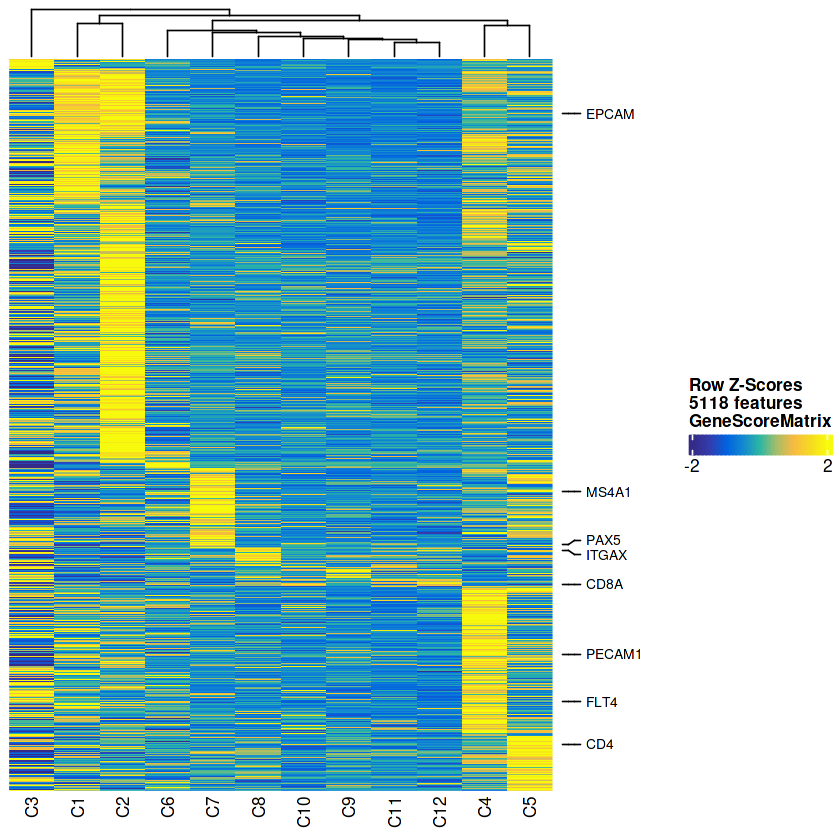

In [28]:
markerGenes <- c("EPCAM",  "VIM", "FLT4", "THY1", "CD3D", "PECAM1", "CD38", "PAX5", "MS4A1", "CD14", "ITGAX", "CD4", "CD8A", "GZMA")

# GScore Heatmap #
heatmapGS <- plotMarkerHeatmap(seMarker = markersGS.slctRes,
                               cutOff = "FDR <= 0.05 & Log2FC >= 1",
                               labelMarkers = markerGenes,
                               transpose = FALSE)
heatmapGS

heatmapGSmatrix <- plotMarkerHeatmap(seMarker = markersGS.slctRes,
                                     cutOff = "FDR <= 0.05 & Log2FC >= 1",
                                     labelMarkers = markerGenes,
                                     returnMatrix = TRUE,
                                     transpose = FALSE)
head(heatmapGSmatrix,10)

write.table(cbind(Cluster=rownames(heatmapGSmatrix),heatmapGSmatrix),sep="\t", row.names=FALSE, col.names=TRUE, quote=FALSE,
            file=file.path(work_dir,paste("GeneScores-Marker-Heatmap",slct.res,sep=".")))



Or visualize GeneScore of marker genes in UMAP


ArchR logging to : ArchRLogs/ArchR-plotEmbedding-33c768bab8e2-Date-2023-07-26_Time-20-11-09.391497.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = GeneScoreMatrix

Getting Matrix Values...

2023-07-26 20:11:09.580211 : 

1 
2 


Plotting Embedding

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-33c768bab8e2-Date-2023-07-26_Time-20-11-09.391497.log



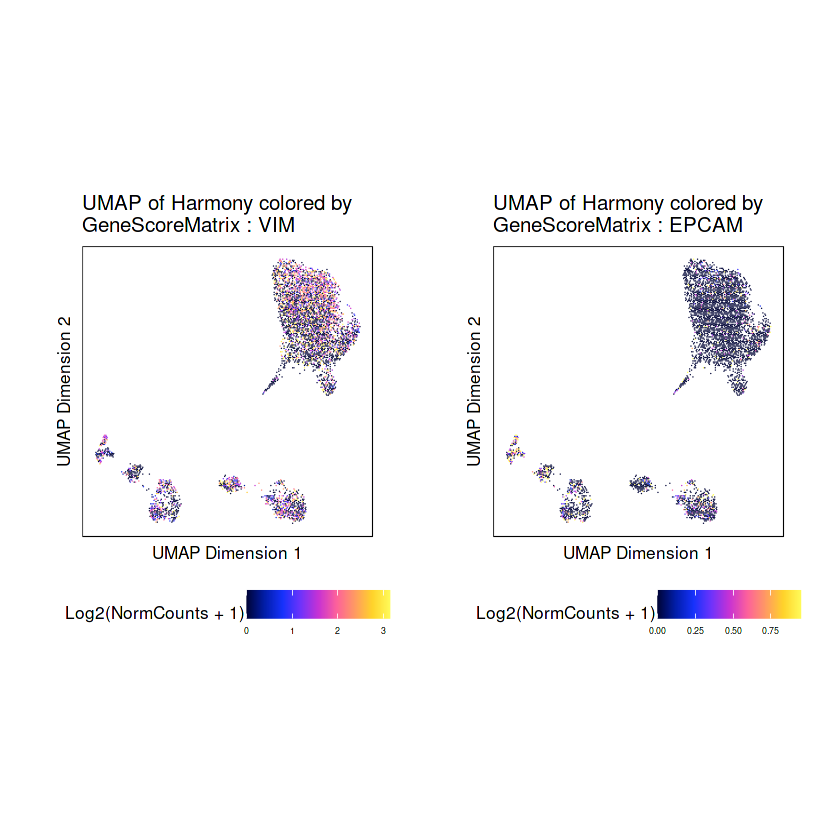

In [29]:
plot.GS.woMAGIC <- plotEmbedding(ArchRProj = project_Normalized, colorBy = "GeneScoreMatrix", name = markerGenes, embedding = "UMAP", quantCut = c(0.01, 0.95), imputeWeights = NULL)

plot.GS.woMAGIC$VIM | plot.GS.woMAGIC$EPCAM


However, scATAC-seq data is really sparse. Due to that, it is highly suggest to use MAGIC (van Dijk, et al., 2018), which add an imputation weight to the gene scores by smoothing signal across nearby cells.



ArchR logging to : ArchRLogs/ArchR-addImputeWeights-33c78767cff-Date-2023-07-26_Time-20-11-17.25008.log
If there is an issue, please report to github with logFile!

2023-07-26 20:11:17.368687 : Computing Impute Weights Using Magic (Cell 2018), 0 mins elapsed.

Getting ImputeWeights

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-33c7516553ea-Date-2023-07-26_Time-20-11-41.264179.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = GeneScoreMatrix

Getting Matrix Values...

2023-07-26 20:11:41.563919 : 

1 
2 


Imputing Matrix

Using weights on disk

1 of 1

Using weights on disk

1 of 1

Plotting Embedding

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-33c7516553ea-Date-2023-07-26_Time-20-11-41.264179.log



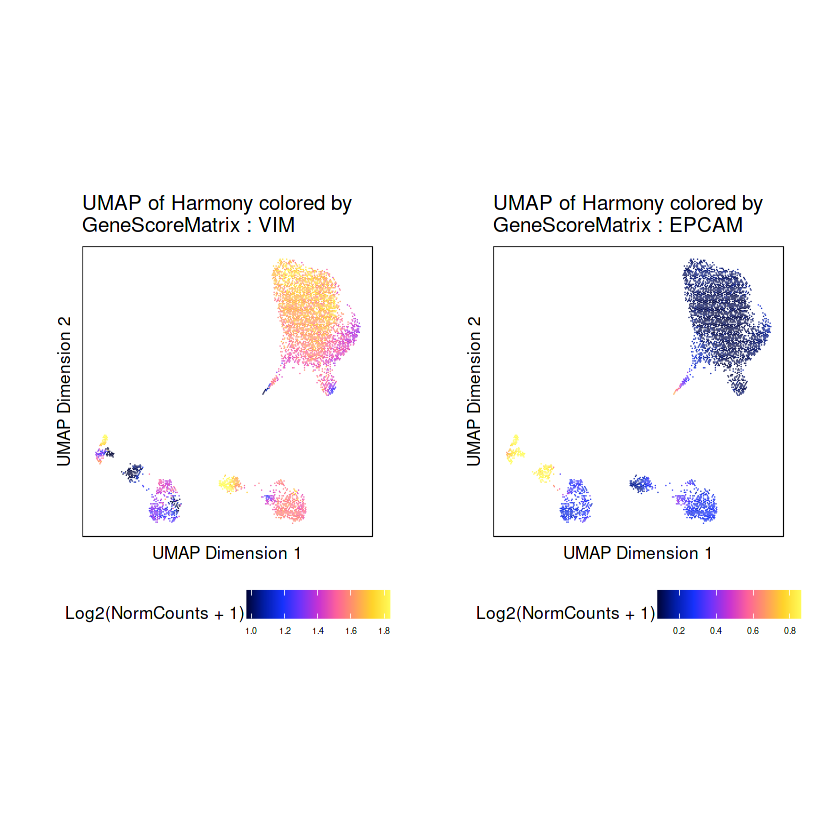

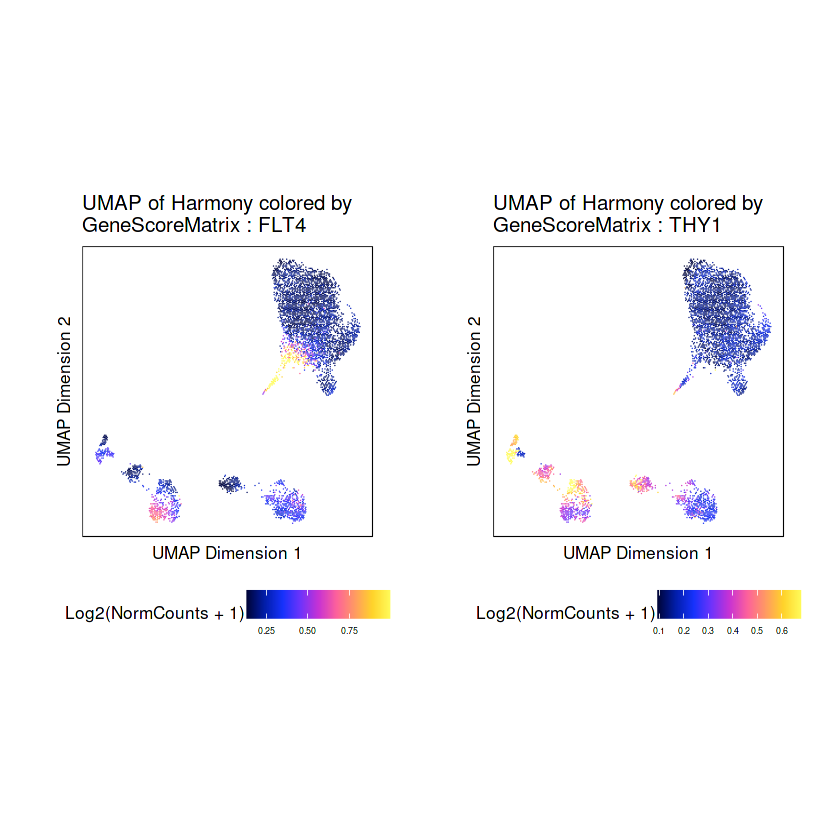

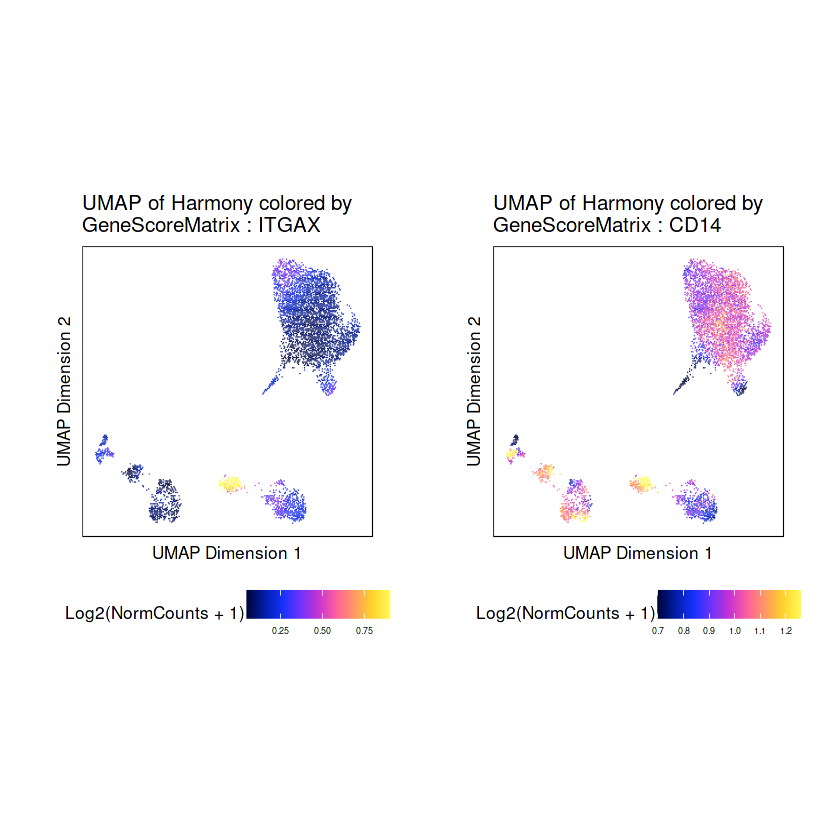

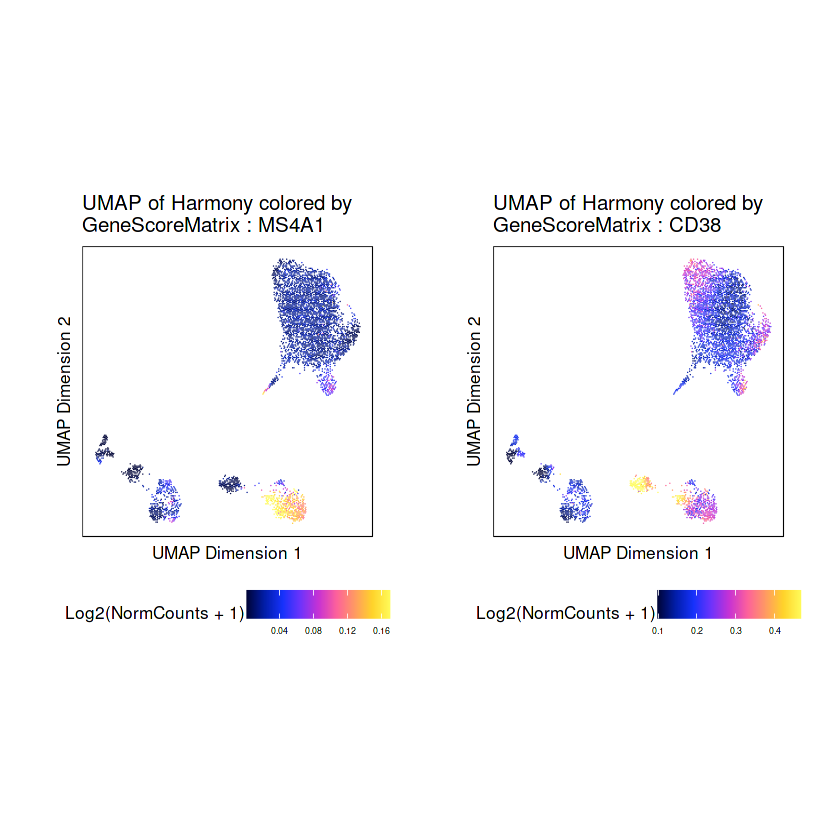

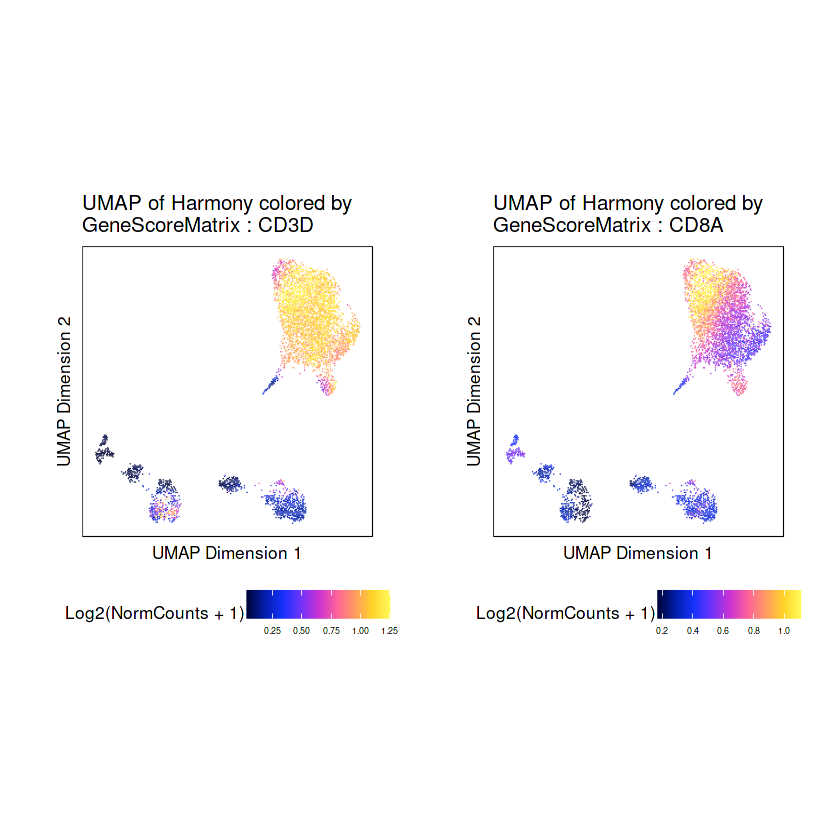

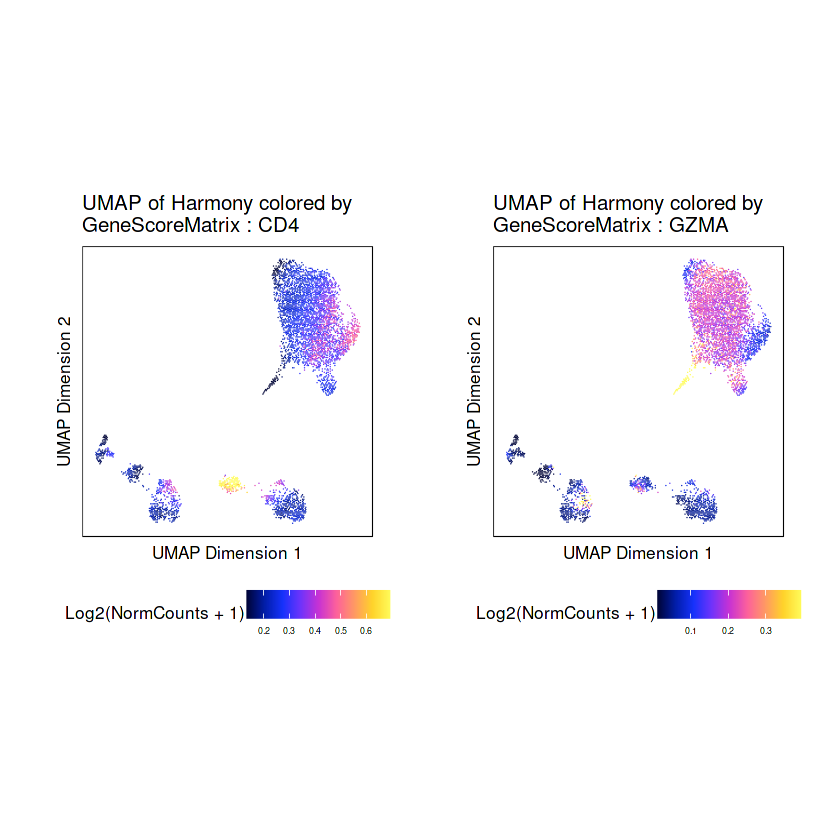

In [30]:
#Perform MAGIC
project_Normalized <- addImputeWeights(project_Normalized)

plot.GS <- plotEmbedding(ArchRProj = project_Normalized, colorBy = "GeneScoreMatrix",
                         name = markerGenes,
                         embedding = "UMAP",
                         imputeWeights = getImputeWeights(project_Normalized))

plot.GS$VIM | plot.GS$EPCAM
plot.GS$FLT4 | plot.GS$THY1
plot.GS$ITGAX | plot.GS$CD14
plot.GS$MS4A1 | plot.GS$CD38
plot.GS$CD3D | plot.GS$CD8A
plot.GS$CD4 | plot.GS$GZMA


#7. scATAC-scRNAseq integration
ArchR enables integration with scRNA-seq, offers the possibility to use clusters called in scRNA-seq space or use the gene expression measurements after integration.

The way this integration works is by directly aligning cells from scATAC-seq with cells from scRNA-seq by comparing the scATAC-seq gene score matrix with the scRNA-seq gene expression matrix. This alignment is performed using the FindTransferAnchors() function from the Seurat package which allows you to align data across two datasets.

However, to appropriately scale this procedure for hundreds of thousands of cells ArchR provides, a parallelization of this procedure by dividing the total cells into smaller groups of cells and performing separate alignments.

In [31]:
# Import scRNAseq data
#scRNA<-readRDS(file.path(work_dir,"scRNAseq.data.rds"))
#DefaultAssay(object = scRNA) <- "RNA"

#project_Normalized <- addGeneIntegrationMatrix(ArchRProj = project_Normalized,
#    useMatrix = "GeneScoreMatrix", matrixName = "GeneIntegrationMatrix",
#    reducedDims = "Harmony", #Harmony , IterativeLSI
#    seRNA = scRNA, addToArrow = TRUE, force= TRUE,
#    groupRNA = "integrated_snn_res.0.5",
#    nameCell = "predictedCell", nameGroup = "predictedGroup", nameScore = "predictedScore",
#    sampleCellsATAC = 10000, sampleCellsRNA = 10000, scaleTo = 10000)
#project_Normalized <- addImputeWeights(project_Normalized)

#saveArchRProject(ArchRProj = project_Normalized, load = FALSE)

#plot_rna.woLabel <- plotEmbedding(project_Normalized,colorBy = "cellColData",name = "predictedGroup", embedding = "UMAP", size=1, labelMeans=FALSE)
#plot_rna <- plotEmbedding(project_Normalized,colorBy = "cellColData",name = "predictedGroup", embedding = "UMAP", size=1)

#Cross table between scRNA-seq and scATAC-seq data
#cM <- as.matrix(confusionMatrix(project$Clusters.res0.7,                #warning resolution
#                                project$predictedGroup))                #warning resolution


#8. Peak calling
Calling peaks is one of the most fundamental processes in ATAC-seq data analysis.
Because per-cell scATAC-seq data is essentially binary (accessible or not accessible), we perform calling peaks on groups of similar cells (or clusters) define previously.

ArchR applies a Iterative Overlap Peak Merging Procedure with the recommanded MACS2 peak caller (Zhang et al., 2008).

It uses a function to perform this iterative overlap peak merging procedure:

1. ArchR would call peaks for each pseudo-bulk replicate individually.

2. ArchR would analyze all of the pseudo-bulk replicates from a single cell type together, performing the first iteration of iterative overlap removal.

3. After the first iteration of iterative overlap removal, ArchR checks to see the reproducibility of each peak across pseudo-bulk replicates and only keeps peaks that pass a threshold indicated by the reproducibility parameter.

4. At the end of this process, we would have a single merged peak set for each cell types.




##8.1. Creation of the pseudo-bulk replicates

In [32]:
nbReplicates=ifelse(length(names(table(project_Normalized$Sample)))>5,length(names(table(project_Normalized$Sample))),5)
project_Peaks <- addGroupCoverages(ArchRProj = project_Normalized, maxReplicates=nbReplicates, groupBy = paste("Clusters",slct.res,sep="."))


ArchR logging to : ArchRLogs/ArchR-addGroupCoverages-33c72a0087ee-Date-2023-07-26_Time-20-12-00.993109.log
If there is an issue, please report to github with logFile!

C1 (1 of 12) : CellGroups N = 2

C2 (2 of 12) : CellGroups N = 2

C3 (3 of 12) : CellGroups N = 2

C4 (4 of 12) : CellGroups N = 2

C5 (5 of 12) : CellGroups N = 2

C6 (6 of 12) : CellGroups N = 2

C7 (7 of 12) : CellGroups N = 2

C8 (8 of 12) : CellGroups N = 2

C9 (9 of 12) : CellGroups N = 2

C10 (10 of 12) : CellGroups N = 2

C11 (11 of 12) : CellGroups N = 2

C12 (12 of 12) : CellGroups N = 2

2023-07-26 20:12:03.0932 : Creating Coverage Files!, 0.035 mins elapsed.

2023-07-26 20:12:03.096668 : Batch Execution w/ safelapply!, 0.035 mins elapsed.

2023-07-26 20:12:03.104642 : Group C1._.Rep1 (1 of 24) : Creating Group Coverage File : C1._.Rep1.insertions.coverage.h5, 0.035 mins elapsed.

Number of Cells = 110

Coverage File Exists!

Added Coverage Group

Added Metadata Group

Added ArrowCoverage Class

Added Coverage

##8.2. Perform peak calling


In [33]:
pathToMacs2<-findMacs2()
project_Peaks <- addReproduciblePeakSet(ArchRProj = project_Peaks,
                                        groupBy = paste("Clusters",slct.res,sep="."),
                                        pathToMacs2 = pathToMacs2)

# It's possible to have difficulty to install macs2 on Windows. In this case, you can use peak calling function developped by ArchR team:

#project_Peaks <- addReproduciblePeakSet(
#    ArchRProj = project_Peaks,
#    groupBy = paste("Clusters",slct.res,sep="."),
#    peakMethod = "Tiles",
#    method = "p")

getPeakSet(project_Peaks)

project_Peaks <- addImputeWeights(project_Peaks)
saveArchRProject(ArchRProj = project_Peaks,
                 outputDirectory = file.path(getwd(),"Analysis_scATACseq"), load = TRUE)


Searching For MACS2..

Found with $path!

ArchR logging to : ArchRLogs/ArchR-addReproduciblePeakSet-33c757081e99-Date-2023-07-26_Time-20-38-52.41913.log
If there is an issue, please report to github with logFile!

Calling Peaks with Macs2

2023-07-26 20:38:52.60964 : Peak Calling Parameters!, 0.003 mins elapsed.



    Group nCells nCellsUsed nReplicates nMin nMax maxPeaks
C1     C1    150        150           2   40  110    75000
C2     C2    195        195           2   47  148    97500
C3     C3     89         89           2   40   49    44500
C4     C4    480        480           2  153  327   150000
C5     C5    209        209           2   61  148   104500
C6     C6    185        185           2   88   97    92500
C7     C7    643        643           2  156  487   150000
C8     C8    417        417           2  188  229   150000
C9     C9    548        548           2  170  378   150000
C10   C10   1165        913           2  413  500   150000
C11   C11   1024        929           2  429  500   150000
C12   C12   1162       1000           2  500  500   150000


2023-07-26 20:38:52.623413 : Batching Peak Calls!, 0.003 mins elapsed.

2023-07-26 20:38:52.637473 : Batch Execution w/ safelapply!, 0 mins elapsed.

2023-07-26 20:38:52.641542 : Group 1 of 24, Calling Peaks with MACS2!, 0 mins elapsed.

Running Macs2 with Params : macs2 callpeak -g 2.7e+09 --name C1._.Rep1-1 --treatment /content/scATACseqWorkshop/Analysis_scATACseq/PeakCalls/InsertionBeds/C1._.Rep1-1.insertions.bed --outdir /content/scATACseqWorkshop/Analysis_scATACseq/PeakCalls/InsertionBeds --format BED --call-summits --keep-dup all --nomodel --nolambda --shift -75 --extsize 150 -q 0.1

2023-07-26 20:39:19.363735 : Group 2 of 24, Calling Peaks with MACS2!, 0.445 mins elapsed.

Running Macs2 with Params : macs2 callpeak -g 2.7e+09 --name C1._.Rep2-2 --treatment /content/scATACseqWorkshop/Analysis_scATACseq/PeakCalls/InsertionBeds/C1._.Rep2-2.insertions.bed --outdir /content/scATACseqWorkshop/Analysis_scATACseq/PeakCalls/InsertionBeds --format BED --call-summits --keep-dup all --nomod

[1] "/content/scATACseqWorkshop/Analysis_scATACseq/PeakCalls/C1-reproduciblePeaks.gr.rds"


Annotating Peaks : Nearest Gene

Annotating Peaks : Gene

Annotating Peaks : TSS

Annotating Peaks : GC



[1] "/content/scATACseqWorkshop/Analysis_scATACseq/PeakCalls/C10-reproduciblePeaks.gr.rds"


Annotating Peaks : Nearest Gene

Annotating Peaks : Gene

Annotating Peaks : TSS

Annotating Peaks : GC



[1] "/content/scATACseqWorkshop/Analysis_scATACseq/PeakCalls/C11-reproduciblePeaks.gr.rds"


Annotating Peaks : Nearest Gene

Annotating Peaks : Gene

Annotating Peaks : TSS

Annotating Peaks : GC



[1] "/content/scATACseqWorkshop/Analysis_scATACseq/PeakCalls/C12-reproduciblePeaks.gr.rds"


Annotating Peaks : Nearest Gene

Annotating Peaks : Gene

Annotating Peaks : TSS

Annotating Peaks : GC



[1] "/content/scATACseqWorkshop/Analysis_scATACseq/PeakCalls/C2-reproduciblePeaks.gr.rds"


Annotating Peaks : Nearest Gene

Annotating Peaks : Gene

Annotating Peaks : TSS

Annotating Peaks : GC



[1] "/content/scATACseqWorkshop/Analysis_scATACseq/PeakCalls/C3-reproduciblePeaks.gr.rds"


Annotating Peaks : Nearest Gene

Annotating Peaks : Gene

Annotating Peaks : TSS

Annotating Peaks : GC



[1] "/content/scATACseqWorkshop/Analysis_scATACseq/PeakCalls/C4-reproduciblePeaks.gr.rds"


Annotating Peaks : Nearest Gene

Annotating Peaks : Gene

Annotating Peaks : TSS

Annotating Peaks : GC



[1] "/content/scATACseqWorkshop/Analysis_scATACseq/PeakCalls/C5-reproduciblePeaks.gr.rds"


Annotating Peaks : Nearest Gene

Annotating Peaks : Gene

Annotating Peaks : TSS

Annotating Peaks : GC



[1] "/content/scATACseqWorkshop/Analysis_scATACseq/PeakCalls/C6-reproduciblePeaks.gr.rds"


Annotating Peaks : Nearest Gene

Annotating Peaks : Gene

Annotating Peaks : TSS

Annotating Peaks : GC



[1] "/content/scATACseqWorkshop/Analysis_scATACseq/PeakCalls/C7-reproduciblePeaks.gr.rds"


Annotating Peaks : Nearest Gene

Annotating Peaks : Gene

Annotating Peaks : TSS

Annotating Peaks : GC



[1] "/content/scATACseqWorkshop/Analysis_scATACseq/PeakCalls/C8-reproduciblePeaks.gr.rds"


Annotating Peaks : Nearest Gene

Annotating Peaks : Gene

Annotating Peaks : TSS

Annotating Peaks : GC



[1] "/content/scATACseqWorkshop/Analysis_scATACseq/PeakCalls/C9-reproduciblePeaks.gr.rds"


2023-07-26 20:53:47.267733 : Creating Union Peak Set!, 14.914 mins elapsed.

Converged after 6 iterations!

Plotting Ggplot!

2023-07-26 20:53:58.961407 : Finished Creating Union Peak Set (70762)!, 15.109 mins elapsed.



GRanges object with 70762 ranges and 13 metadata columns:
      seqnames              ranges strand |     score replicateScoreQuantile
         <Rle>           <IRanges>  <Rle> | <numeric>              <numeric>
  C11     chr1       752439-752939      * |   6.06349                  0.254
   C4     chr1       762579-763079      * |  14.49660                  0.841
  C11     chr1       804999-805499      * |  61.39750                  0.770
   C2     chr1       846245-846745      * |   2.79335                  0.246
   C1     chr1       856336-856836      * |   4.97585                  0.807
  ...      ...                 ...    ... .       ...                    ...
   C2     chrX 154299482-154299982      * |  58.51930                  0.951
  C10     chrX 154314644-154315144      * |   5.62975                  0.588
   C2     chrX 154444440-154444940      * |  95.53520                  0.980
   C9     chrX 154493570-154494070      * |  67.38340                  0.890
   C5     chrX 154

ArchR logging to : ArchRLogs/ArchR-addImputeWeights-33c7bc423f1-Date-2023-07-26_Time-20-53-58.993728.log
If there is an issue, please report to github with logFile!

2023-07-26 20:53:59.053724 : Computing Impute Weights Using Magic (Cell 2018), 0 mins elapsed.

Saving ArchRProject...

Loading ArchRProject...

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
      

class: ArchRProject 
outputDirectory: /content/scATACseqWorkshop/Analysis_scATACseq 
samples(2): P41 P93
sampleColData names(1): ArrowFiles
cellColData names(25): Sample TSSEnrichment ... Clusters.res0.8
  Clusters.res0.9
numberOfCells(1): 6267
medianTSS(1): 26.466
medianFrags(1): 3070

##8.3. Identification of marker peaks
As explained before for the marker genes, ArchR can used gene, peak or transcription factor motif features. Here, ArchR identify the peaks that appear to be uniquely active in each cluster at selected resolution.


In [34]:
project_Peaks <- addPeakMatrix(project_Peaks)

markersPeaks <- getMarkerFeatures(ArchRProj = project_Peaks,
                                  useMatrix = "PeakMatrix",
                                  groupBy = paste("Clusters",slct.res,sep="."),
                                  bias = c("TSSEnrichment", "log10(nFrags)"),
                                  testMethod = "wilcoxon")

markerList <- getMarkers(markersPeaks, cutOff = "FDR <= 0.01 & Log2FC >= 1")

#marker peaks for the cluster 1
markerList[["C9"]]


ArchR logging to : ArchRLogs/ArchR-addPeakMatrix-33c714347237-Date-2023-07-26_Time-20-54-29.672032.log
If there is an issue, please report to github with logFile!

2023-07-26 20:54:29.806557 : Batch Execution w/ safelapply!, 0 mins elapsed.

2023-07-26 20:54:30.238459 : Adding P93 to PeakMatrix for Chr (1 of 23)!, 0.006 mins elapsed.

2023-07-26 20:54:34.569634 : Adding P93 to PeakMatrix for Chr (2 of 23)!, 0.078 mins elapsed.

2023-07-26 20:54:38.078998 : Adding P93 to PeakMatrix for Chr (3 of 23)!, 0.136 mins elapsed.

2023-07-26 20:54:41.024248 : Adding P93 to PeakMatrix for Chr (4 of 23)!, 0.186 mins elapsed.

2023-07-26 20:54:44.102393 : Adding P93 to PeakMatrix for Chr (5 of 23)!, 0.237 mins elapsed.

2023-07-26 20:54:46.948293 : Adding P93 to PeakMatrix for Chr (6 of 23)!, 0.284 mins elapsed.

2023-07-26 20:54:50.491519 : Adding P93 to PeakMatrix for Chr (7 of 23)!, 0.343 mins elapsed.

2023-07-26 20:54:53.327465 : Adding P93 to PeakMatrix for Chr (8 of 23)!, 0.391 mins elapsed.

DataFrame with 49 rows and 7 columns
      seqnames     idx     start       end    Log2FC         FDR  MeanDiff
         <Rle> <array>   <array>   <array> <numeric>   <numeric> <numeric>
22560    chr15    1162  70488943  70489443   2.60327 9.74009e-06  0.398198
64713     chr8    1511  95254237  95254737   2.51004 9.74009e-06  0.282160
16920    chr12    2369 109250150 109250650   1.86472 1.96697e-05  0.510983
17733    chr12    3182 131590392 131590892   2.66200 2.42510e-05  0.502711
55695     chr5    2494 159894605 159895105   2.06144 3.20381e-05  0.561191
...        ...     ...       ...       ...       ...         ...       ...
30920    chr17    3938  77777937  77778437   4.87929  0.00763652  0.182621
16701    chr12    2150  99147863  99148363   4.81402  0.00763930  0.219516
16989    chr12    2438 110787480 110787980   4.46739  0.00778311  0.252571
46559    chr22    1185  39496061  39496561   2.67171  0.00798799  0.219867
4953      chr1    4953 167606936 167607436   5.80320  0.0085577


To visualize the marker genes, we can produce a heatmap:


ArchR logging to : ArchRLogs/ArchR-plotMarkerHeatmap-33c71e046560-Date-2023-07-26_Time-21-04-22.80188.log
If there is an issue, please report to github with logFile!

Identified 22853 markers!



  [1] "chr1:3459912-3460412"      "chr1:6579870-6580370"     
  [3] "chr1:7740352-7740852"      "chr1:9527042-9527542"     
  [5] "chr1:10695510-10696010"    "chr1:10864339-10864839"   
  [7] "chr1:16538781-16539281"    "chr1:18807149-18807649"   
  [9] "chr1:21960517-21961017"    "chr1:26857609-26858109"   
 [11] "chr1:31867419-31867919"    "chr1:45279294-45279794"   
 [13] "chr1:59892683-59893183"    "chr1:62207868-62208368"   
 [15] "chr1:72748337-72748837"    "chr1:901586-902086"       
 [17] "chr1:937136-937636"        "chr1:960007-960507"       
 [19] "chr1:1015424-1015924"      "chr1:1067898-1068398"     
 [21] "chr1:1093328-1093828"      "chr1:1207805-1208305"     
 [23] "chr1:1244403-1244903"      "chr1:1245094-1245594"     
 [25] "chr1:1266175-1266675"      "chr1:1268080-1268580"     
 [27] "chr1:1283265-1283765"      "chr1:1299599-1300099"     
 [29] "chr1:1494410-1494910"      "chr1:1610002-1610502"     
 [31] "chr1:856336-856836"        "chr1:875808-876308"       
 [33] "c

Preparing Main Heatmap..

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

ArchR logging successful to : ArchRLogs/ArchR-plotMarkerHeatmap-33c71e046560-Date-2023-07-26_Time-21-04-22.80188.log



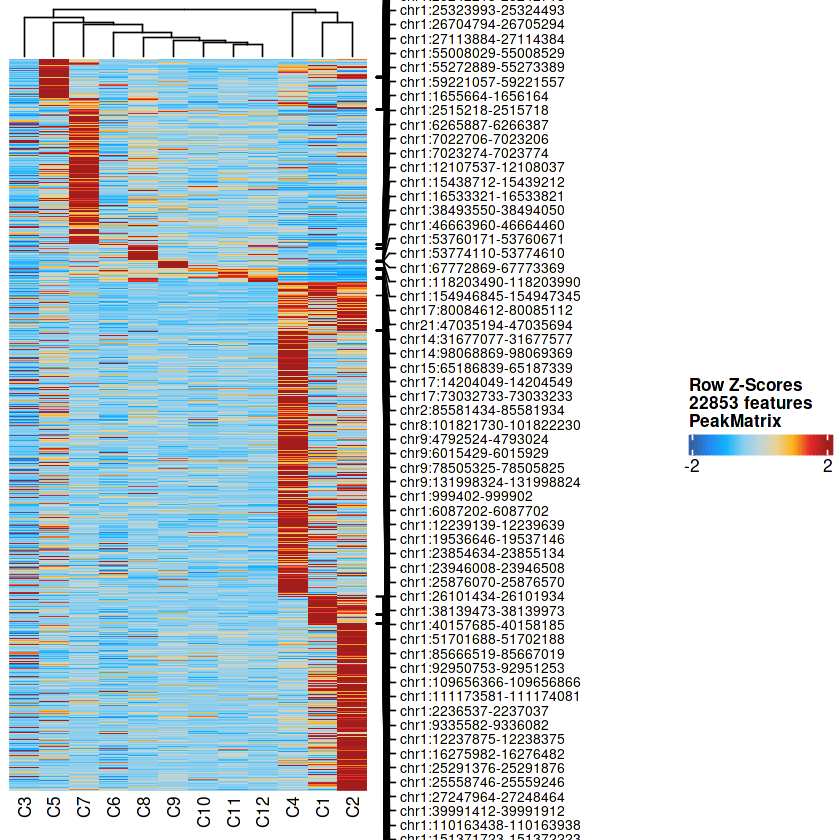

In [35]:
heatmapPeaks <- plotMarkerHeatmap(seMarker = markersPeaks,
                                  cutOff = "FDR <= 0.1 & Log2FC >= 0.5",
                                  transpose = FALSE)

heatmapPeaks

#Remarks:
#To obtain the matrix, use parameters: returnMatrix = TRUE



Or MA and volcano plots of marker peaks by cluster:


Warning message:
“Removed 24 rows containing missing values (`geom_point_rast()`).”
Warning message:
“Removed 24 rows containing missing values (`geom_point_rast()`).”


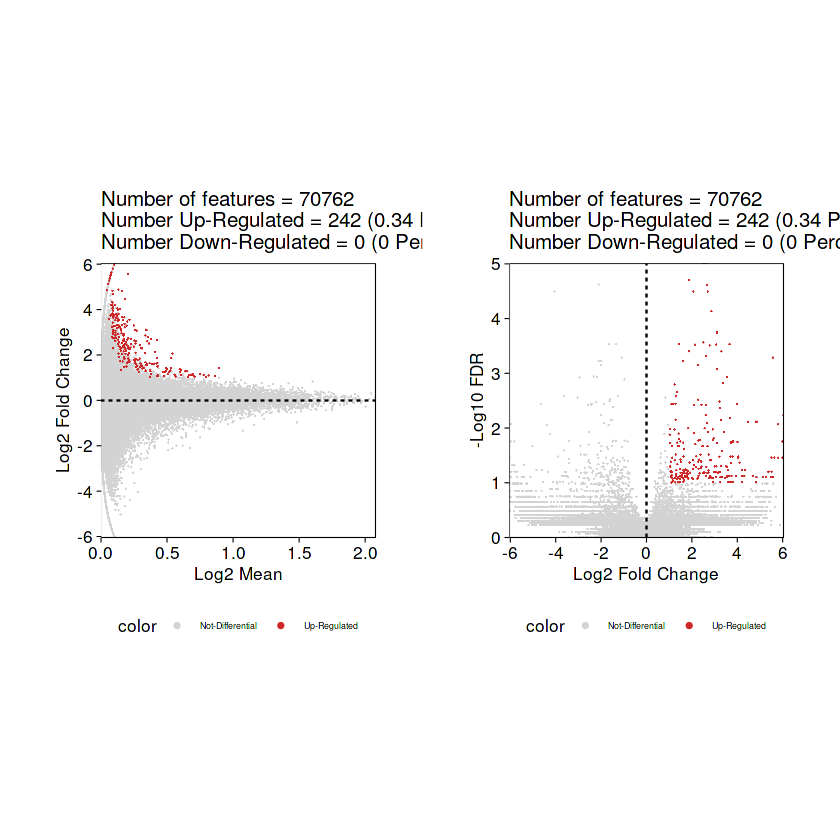

In [36]:
# Figures for the cluster CD4 naive:
map<- plotMarkers(seMarker = markersPeaks, name = "C9",
                  cutOff = "FDR <= 0.1 & Log2FC >= 1",        #default
                  plotAs = "MA")
vp <- plotMarkers(seMarker = markersPeaks, name = "C9",
                  cutOff = "FDR <= 0.1 & Log2FC >= 1",         #default
                  plotAs = "Volcano")

map | vp



Or visualize the marker peaks on a browser track:


In [37]:
# For the cluster 1:
plot.track1 <- plotBrowserTrack(ArchRProj = project_Peaks,
                                groupBy = paste("Clusters",slct.res,sep="."),
                                geneSymbol = c("CD4"),
                                features =  getMarkers(markersPeaks, cutOff = "FDR <= 0.1 & Log2FC >= 1", returnGR = TRUE)["C9"],
                                upstream = 50000, downstream = 50000)

grid::grid.newpage()
grid::grid.draw(plot.track1$CD8A)


ArchR logging to : ArchRLogs/ArchR-plotBrowserTrack-33c753dc05be-Date-2023-07-26_Time-21-04-58.641986.log
If there is an issue, please report to github with logFile!

2023-07-26 21:04:58.70972 : Validating Region, 0.001 mins elapsed.



GRanges object with 1 range and 2 metadata columns:
      seqnames          ranges strand |     gene_id      symbol
         <Rle>       <IRanges>  <Rle> | <character> <character>
  [1]    chr12 6898638-6929976      + |         920         CD4
  -------
  seqinfo: 24 sequences from hg19 genome


2023-07-26 21:04:58.790861 : Adding Bulk Tracks (1 of 1), 0.002 mins elapsed.

Getting Region From Arrow Files 1 of 2

Getting Region From Arrow Files 2 of 2

2023-07-26 21:05:00.429788 : Adding Feature Tracks (1 of 1), 0.03 mins elapsed.

2023-07-26 21:05:00.598733 : Adding Gene Tracks (1 of 1), 0.033 mins elapsed.

2023-07-26 21:05:01.063668 : Plotting, 0.04 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-plotBrowserTrack-33c753dc05be-Date-2023-07-26_Time-21-04-58.641986.log



In [38]:
#Save the object and download it!!
saveRDS(project_Peaks,"project_Peaks.rds")
saveRDS(markersPeaks,"markersPeaks.rds")

#9. Motif Enrichment
After identified peak sets, the next step is to predict what transcription factors may be mediating the binding events that create those accessible chromatin sites.
ArchR allow to annotate the TF motifs that are enriched in peaks that are up or down in the different cell types.
Firstly, we add motif annotations to our ArchRProject based on a reference database (for example: CIS-BP, JASPAR, Encode or Homer). Here, we have selected CIS-BP which contains > 300 TF families from > 700 species collecting from > 70 sources , including other databases: Transfac, JASPAR, Hocomoco, FactorBook, UniProbe, ...
Next, we test the set of significantly differential peaks for motif enrichment.


In [39]:
shell_call("gdown 1SdSmF9R3yHNWacmFf22RxpcrrKmUHM_b")
markersPeaks = readRDS("markersPeaks.rds")
shell_call("gdown 1S6fRM7_KX4kjd9ankvzA5HloJJSIM4bn")
project_Peaks = readRDS("project_Peaks.rds")

Warning message in system(command, intern = TRUE, ...):
“running command 'gdown 1SdSmF9R3yHNWacmFf22RxpcrrKmUHM_b' had status 1”


Access denied with the following error:

Warning message in system(command, intern = TRUE, ...):
“running command 'gdown 1S6fRM7_KX4kjd9ankvzA5HloJJSIM4bn' had status 1”


Access denied with the following error:

In [40]:
##Motif Enrichment
project_Peaks <- addMotifAnnotations(ArchRProj = project_Peaks, motifSet = "cisbp", name = "Motif", force = TRUE)

#Motif enrichment in marker peaks
enrichMotifs <- peakAnnoEnrichment(
    seMarker = markersPeaks, ArchRProj = project_Peaks,
    peakAnnotation = "Motif",cutOff = "FDR <= 0.1 & Log2FC >= 0.5")        #default

#You have 2 output, the Enrichment matrix and the pvalue matrix:
head(enrichMotifs@assays@data$Enrichment,10)


ArchR logging to : ArchRLogs/ArchR-addMotifAnnotations-33c74092af63-Date-2023-07-26_Time-21-05-15.463151.log
If there is an issue, please report to github with logFile!

2023-07-26 21:05:18.212316 : Gettting Motif Set, Species : Homo sapiens, 0.001 mins elapsed.



ERROR: ignored

We can display a heatmap to visualize the main motifs of each clusters.


In [ ]:
heatmapEM <- plotEnrichHeatmap(enrichMotifs, n = 7, transpose = TRUE)
ComplexHeatmap::draw(heatmapEM, heatmap_legend_side = "bot", annotation_legend_side = "bot")

##9.1. ChromVAR and visualization of motif deviation
ChromVAR, developed by Greenleaf lab, is designed for predicting enrichment of TF activity on a per-cell basis from sparse chromatin accessibility data.
ChromVAR computes:
1. A “deviation”, which is a bias-corrected measurement of how far the per-cell accessibility of a given feature (i.e motif) deviates from the expected accessibility based on the average of all cells or samples.
2. A “z-score” / a “deviation score”, which is the z-score for each bias-corrected deviation across all cells.


In [ ]:
project_Peaks <- addBgdPeaks(project_Peaks)

project_Peaks <- addDeviationsMatrix(ArchRProj = project_Peaks, peakAnnotation = "Motif",force = TRUE)

getVarDeviations(project_Peaks, name = "MotifMatrix", plot = TRUE)

saveArchRProject(ArchRProj = project_Normalized,
                 outputDirectory = file.path(getwd(),"Analysis_scATACseq"))



We can display a distribution of markers


In [ ]:
motifs <- c("FOS", "JUNB")

markerMotifs <- getFeatures(project_Peaks, select = paste(motifs,"_", collapse="|",sep=""), useMatrix = "MotifMatrix")

markerMotifs <- grep("z:", markerMotifs, value = TRUE)

project_Peaks <- addImputeWeights(project_Peaks)

cowp<-plotGroups(ArchRProj = project_Peaks,
  groupBy = paste("Clusters",slct.res,sep="."), colorBy = "MotifMatrix",
  name = markerMotifs,imputeWeights = getImputeWeights(project_Peaks))
do.call(cowplot::plot_grid, c(list(ncol = 2),cowp))



Or visualize the motif deviation in UMAP (and see if motif deviation correlates with TF gene score)


In [ ]:
motif.umap <- plotEmbedding(ArchRProj = project_Peaks,
    colorBy = "MotifMatrix", name = sort(markerMotifs), embedding = "UMAP",
    imputeWeights = getImputeWeights(project_Peaks))

do.call(cowplot::plot_grid, c(list(ncol = 2),motif.umap))

markerRNA <- getFeatures(project_Peaks, select = paste(motifs,"$", collapse="|", sep=""), useMatrix = "GeneScoreMatrix")

gene.umap <- plotEmbedding(ArchRProj = project_Peaks,
    colorBy = "GeneScoreMatrix",name = sort(markerRNA), embedding = "UMAP",
    imputeWeights = getImputeWeights(project_Peaks))

do.call(cowplot::plot_grid, c(list(ncol = 2),gene.umap))


##9.2. Pairwise test between clusters
We can identify the motif enrichment between two clusters (based on differential accessibility of peaks between these two clusters).


In [ ]:
slct.Cl1="C9"
slct.Cl2="C11"

markerTest <- getMarkerFeatures(ArchRProj = project_Peaks,
                                useMatrix = "PeakMatrix",
                                groupBy = paste("Clusters",slct.res,sep="."),
                                testMethod = "wilcoxon",
                                bias = c("TSSEnrichment", "log10(nFrags)"),
                                useGroups = slct.Cl1, bgdGroups = slct.Cl2)

map.Cl1vCl2 <- markerPlot(seMarker = markerTest, name = slct.Cl1,
                        cutOff = "FDR <= 0.1 & abs(Log2FC) >= 1",
                        plotAs = "MA")
vp.Cl1vCl2 <- markerPlot(seMarker = markerTest, name = slct.Cl1,
                       cutOff = "FDR <= 0.1 & abs(Log2FC) >= 1",
                       plotAs = "Volcano")

map.Cl1vCl2 | vp.Cl1vCl2



Motif Up-Enrich and motif Down-enrich (based on the pairwise test between clusters)


In [ ]:
motifsUp <- peakAnnoEnrichment(ArchRProj = project_Peaks,
                               seMarker = markerTest,
                               peakAnnotation = "Motif",
                               cutOff = "FDR <= 0.1 & Log2FC >= 0.5")

df <- data.frame(TF = rownames(motifsUp), mlog10Padj = assay(motifsUp)[,1])
df <- df[order(df$mlog10Padj, decreasing = TRUE),]
df$rank <- seq_len(nrow(df))

ggUp <- ggplot(df, aes(rank, mlog10Padj, color = mlog10Padj)) +
    geom_point(size = 1) + ggrepel::geom_label_repel(
        data = df[rev(seq_len(30)), ], aes(x = rank, y = mlog10Padj, label = TF),
        size = 1.5,nudge_x = 2,color = "black") + theme_ArchR() +
        ylab("-log10(P-adj) Motif Enrichment") + xlab("Rank Sorted TFs Enriched") +
        scale_color_gradientn(colors = paletteContinuous(set = "comet"))

motifsDo <- peakAnnoEnrichment(ArchRProj = project_Peaks,
                               seMarker = markerTest,
                               peakAnnotation = "Motif",
                               cutOff = "FDR <= 0.1 & Log2FC <= -0.5")

df <- data.frame(TF = rownames(motifsDo), mlog10Padj = assay(motifsDo)[,1])
df <- df[order(df$mlog10Padj, decreasing = TRUE),]
df$rank <- seq_len(nrow(df))

ggDo <- ggplot(df, aes(rank, mlog10Padj, color = mlog10Padj)) +
    geom_point(size = 1) + ggrepel::geom_label_repel(
        data = df[rev(seq_len(30)), ], aes(x = rank, y = mlog10Padj, label = TF),
        size = 1.5,nudge_x = 2,color = "black") + theme_ArchR() +
        ylab("-log10(FDR) Motif Enrichment") + xlab("Rank Sorted TFs Enriched") +
        scale_color_gradientn(colors = paletteContinuous(set = "comet"))

ggUp | ggDo


#10. Identification of Positive TF-Regulators
Although ATAC-seq allows unbiased identification of TFs, families of TFs share similar motifs when viewed in aggregate.
This makes it difficult to identify specific TFs that may be responsible for the observed changes in chromatin accessibility to their predicted binding sites. To circumvent this problem, ArchR identifies TFs whose gene expression (Gene score) is positively correlated with changes in accessibility of their corresponding motif (Motif deviation obtained using ChromVAR).




##Step 1. Identify Deviant TF Motifs

In [ ]:
seGroupMotif <- getGroupSE(ArchRProj = project_Peaks, useMatrix = "MotifMatrix", groupBy = paste("Clusters",slct.res,sep="."))

#We take the deviation z-scores
seZ <- seGroupMotif[rowData(seGroupMotif)$seqnames=="z",]

#We identify the maximum delta in z-score between all clusters to stratify motifs based on the degree of variation observed across clusters.
rowData(seZ)$maxDelta <- lapply(seq_len(ncol(seZ)), function(x){
  rowMaxs(assay(seZ) - assay(seZ)[,x])
}) %>% Reduce("cbind", .) %>% rowMaxs



##Step 2. Identify Correlated TF Motifs and TF Gene Score/Expression


In [ ]:
corGSM_MM <- correlateMatrices(
    ArchRProj = project_Peaks,
    useMatrix1 = "GeneScoreMatrix",
    useMatrix2 = "MotifMatrix",
    reducedDims = "Harmony" #Harmony , IterativeLSI
)

head(corGSM_MM,15)


##Step 3. Add Maximum Delta Deviation to the Correlation Data Frame


In [ ]:
#We annotate each motif with the maximum delta observed between clusters
corGSM_MM$maxDelta <- rowData(seZ)[match(corGSM_MM$MotifMatrix_name, rowData(seZ)$name), "maxDelta"]



##Step 4. Identify Positive TF Regulators


In [ ]:
#We can use all of this information to identify positive (and negative) TF regulators
corGSM_MM <- corGSM_MM[order(abs(corGSM_MM$cor), decreasing = TRUE), ]
corGSM_MM <- corGSM_MM[which(!duplicated(gsub("\\-.*","",corGSM_MM[,"MotifMatrix_name"]))), ]
corGSM_MM$TFRegulator <- "NO"
corGSM_MM$TFRegulator[which(corGSM_MM$cor > 0.1 & corGSM_MM$padj < 0.01 & corGSM_MM$maxDelta > quantile(corGSM_MM$maxDelta, 0.75))] <- "PLUS"
corGSM_MM$TFRegulator[which(corGSM_MM$cor < (-0.1) & corGSM_MM$padj < 0.01 & corGSM_MM$maxDelta > quantile(corGSM_MM$maxDelta, 0.75))] <- "NEG"

ggplot(data.frame(corGSM_MM), aes(cor, maxDelta, color = TFRegulator)) +
  geom_point() +
  theme_ArchR() +
  geom_vline(xintercept = 0, lty = "dashed") +
  scale_color_manual(values = c("NO"="darkgrey", "PLUS"="firebrick3", "NEG"="royalblue1")) +
  xlab("Correlation To Gene Score") +
  ylab("Max TF Motif Delta") +
  scale_y_continuous(
    expand = c(0,0),
    limits = c(0, max(corGSM_MM$maxDelta)*1.05)
  )

head(as.matrix(sort(corGSM_MM[corGSM_MM$TFRegulator=="PLUS",c("GeneScoreMatrix_name","MotifMatrix_name","cor","padj","maxDelta")])),15)
head(as.matrix(sort(corGSM_MM[corGSM_MM$TFRegulator=="NEG",c("GeneScoreMatrix_name","MotifMatrix_name","cor","padj","maxDelta")])),5)


#11. Co-accessibility
To study how the genes are regulated (promoter and enhancer links) ArchR proposes Co-accessibility analysis.
Co-accessibility is a correlation in accessibility between two peaks across many single cells. Said another way, when Peak A is accessible in a single cell, Peak B is often also accessible.
For example, co-accessibility allows to visualize the enhancer(s) linked to the gene promoter.
<center>

![<i><font size=1 color="grey">from ArchR manual</font></i>](./Figures/ArchR_Coaccessibility.png){width=50% height=50%}

</center>
Remarks:Co-accessibility analysis identify cell type-specific peaks. Although these peaks are often accessible together within a single cell type (and often all not accessible in all other cell types) does not necessarily explain a regulatory relationship between these peaks.


In [ ]:
project_Peaks <- addCoAccessibility(ArchRProj = project_Peaks,
                                    reducedDims = "Harmony") #Harmony , IterativeLSI

cA <- getCoAccessibility(
    ArchRProj = project_Peaks,
    corCutOff = 0.5,
    resolution = 10000,
    returnLoops = TRUE
)

head(cA$CoAccessibility,10)

p <- plotBrowserTrack(
    ArchRProj = project_Peaks,
    groupBy = paste("Clusters",slct.res,sep="."),
    geneSymbol = markerGenes,
    upstream = 50000,
    downstream = 50000,
    loops = getCoAccessibility(project_Peaks)
)

grid::grid.newpage()
grid::grid.draw(p$CD8A)


#12. Footprinting
Transcription factor (TF) footprinting allows for the prediction of the precise binding location of a TF at a particular locus. This is because the DNA bases that are directly bound by the TF are actually protected from transposition while the DNA bases immediately adjacent to TF binding are accessible.



In [ ]:
#To obtain the positions of relevant motifs
motifPositions <- getPositions(project_Peaks)

markerMotifs=gsub("z:","",markerMotifs)

seFoot <- getFootprints(
  ArchRProj = project_Peaks,
  positions = motifPositions[markerMotifs],
  groupBy = paste("Clusters",slct.res,sep=".")
)

# Remarks: It is possible to apply a normalization to correct the biases due to the cutting of Tn5.
plotFootprints(seFoot = seFoot,
               ArchRProj = project_Peaks,
               normMethod = "Subtract", #Divide or None
               plotName = paste("Footprints-Subtract-Bias",slct.res,"cisbp",sep="."),
               addDOC = FALSE,
               smoothWindow = 5)


#13. Trajectory Analysis
ArchR proposes to create a cellular trajectory that approximates the differentiation from a cell cluster to an other one.
After the definition of the trajectory backbone, which consist of an ordered vector of cell group labels, ArchR identify a pseudo-time value for each cell in the trajectory.
In the results, ArchR provides UMAPs to visualize the pseudo-temporal trajectory and heatmaps to track spike/pattern/gene signals as a function of pseudo-temporality.




##13.1. Construction of trajectory
Firstly, ArchR produces a pseudo-time value for each cell in the trajectory, which can be visualize on UMAP and used to display an arrow approximating the trajectory path from the spline-fit.

In [ ]:
trajectory <- c("C9","C11"); traj.name="TF.C9.C11"        #C9 CD4 --> C11 CD4

project_Peaks <- addTrajectory(
    ArchRProj = project_Peaks,
    name = traj.name,
    groupBy = paste("Clusters",slct.res,sep="."),
    trajectory = trajectory,
    embedding = "UMAP",
    force = TRUE
)

plotTraj<-plotTrajectory(project_Peaks, trajectory = traj.name, colorBy = "cellColData", name = traj.name, embedding = "UMAP")

plotTraj[[1]]


##13.2. Observation of specific genes
It's possible to visualize this trajectory but color the cells by a specific gene score value.


In [ ]:
p_gene <- plotTrajectory(project_Peaks, trajectory = traj.name, colorBy = "GeneScoreMatrix", name = "CD4", continuousSet = "horizonExtra", embedding = "UMAP")

p_gene[[1]] | p_gene[[2]]


##13.3 Pseudo-time heatmaps
Finally, ArchR allow to perform heatmap to visualize changes in many features (peaks, gene scores or motifs) across pseudo-time.


In [ ]:
trajGSM <- getTrajectory(ArchRProj = project_Peaks, name = traj.name, useMatrix = "GeneScoreMatrix", log2Norm = TRUE)

p_trajGSM <- plotTrajectoryHeatmap(trajGSM,  pal = paletteContinuous(set = "horizonExtra"))
p_trajGSM.matrix <- plotTrajectoryHeatmap(trajGSM,  pal = paletteContinuous(set = "horizonExtra"), returnMatrix = T)

trajPM  <- getTrajectory(ArchRProj = project_Peaks, name = traj.name, useMatrix = "PeakMatrix", log2Norm = TRUE)

p_trajPM <- plotTrajectoryHeatmap(trajPM, pal = paletteContinuous(set = "solarExtra"))
p_trajPM.matrix <- plotTrajectoryHeatmap(trajPM, pal = paletteContinuous(set = "solarExtra"), returnMatrix = T)

trajMM  <- getTrajectory(ArchRProj = project_Peaks, name = traj.name, useMatrix = "MotifMatrix", log2Norm = FALSE)

p_trajMM <- plotTrajectoryHeatmap(trajMM, pal = paletteContinuous(set = "solarExtra"))
p_trajMM.matrix <- plotTrajectoryHeatmap(trajMM, pal = paletteContinuous(set = "solarExtra"), returnMatrix = T)

p_trajGSM
p_trajPM
p_trajMM


##13.3. Integrative pseudo-time analysis

As shown before, ArchR allows also to perform integrative analysis to identify positive transcription factor using gene scores and motif accessibility across pseudo-time, follow their variability across pseudo-time and understand their role in this trajectory. To do it, ArchR proposes to use the correlateTrajectories() function which takes two SummarizedExperiment objects obtained from the getTrajectories() function which we have obtained before.


Step 1. Identify and select the  motifs which gene score and TF motif accessibility is correlated:


In [ ]:
corGSM_MM <- correlateTrajectories(trajGSM, trajMM,
                                   corCutOff = 0.2, varCutOff1 = 0.5, varCutOff2 = 0.5) # low stringency criteria

flt_trajGSM <- trajGSM[corGSM_MM[[1]]$name1, ]
flt_trajMM <- trajMM[corGSM_MM[[1]]$name2, ]


Step 2. Create a new trajectory two visualize side by side the TF motif based on gene score and TF motif enrichment:



In [ ]:
combinedTraj <- flt_trajGSM
assay(combinedTraj, withDimnames=FALSE) <- t(apply(assay(flt_trajGSM), 1, scale)) + t(apply(assay(flt_trajMM), 1, scale))

combinedMat <- plotTrajectoryHeatmap(combinedTraj, returnMat = TRUE, varCutOff = 0)

rowOrder <- match(rownames(combinedMat), rownames(flt_trajGSM))

ht_GSM <- plotTrajectoryHeatmap(flt_trajGSM,  pal = paletteContinuous(set = "horizonExtra"),  varCutOff = 0, rowOrder = rowOrder)
ht_MM <- plotTrajectoryHeatmap(flt_trajMM, pal = paletteContinuous(set = "solarExtra"), varCutOff = 0, rowOrder = rowOrder)
ht_GSM+ht_MM



#Session Information


In [ ]:
sessionInfo()

